### ライブラリのImport

In [1]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

from dsets_for_old import getRect
from dsets_for_old import getOneDiceImageInfoListFromRecWidth
from sklearn.cluster import SpectralClustering

### データの読み込み

In [2]:
# 画像データ読み込み
X_train = np.load('/mnt/c/Users/user/MyData/SonyDice/X_train_renew.npy')
X_train = np.reshape(X_train, [200000, 20, 20])
X_train.shape

(200000, 20, 20)

In [4]:
X_test = np.load('/mnt/c/Users/user/MyData/SonyDice/X_test.npy')
X_test = np.reshape(X_test, [-1, 20, 20])
X_test.shape

(24922, 20, 20)

In [72]:
# ラベルデータ読み込み
y_train = np.load('/mnt/c/Users/user/MyData/SonyDice/y_train.npy')
y_train.shape

(200000,)

### 可視化と矩形検出

In [5]:
n = 50

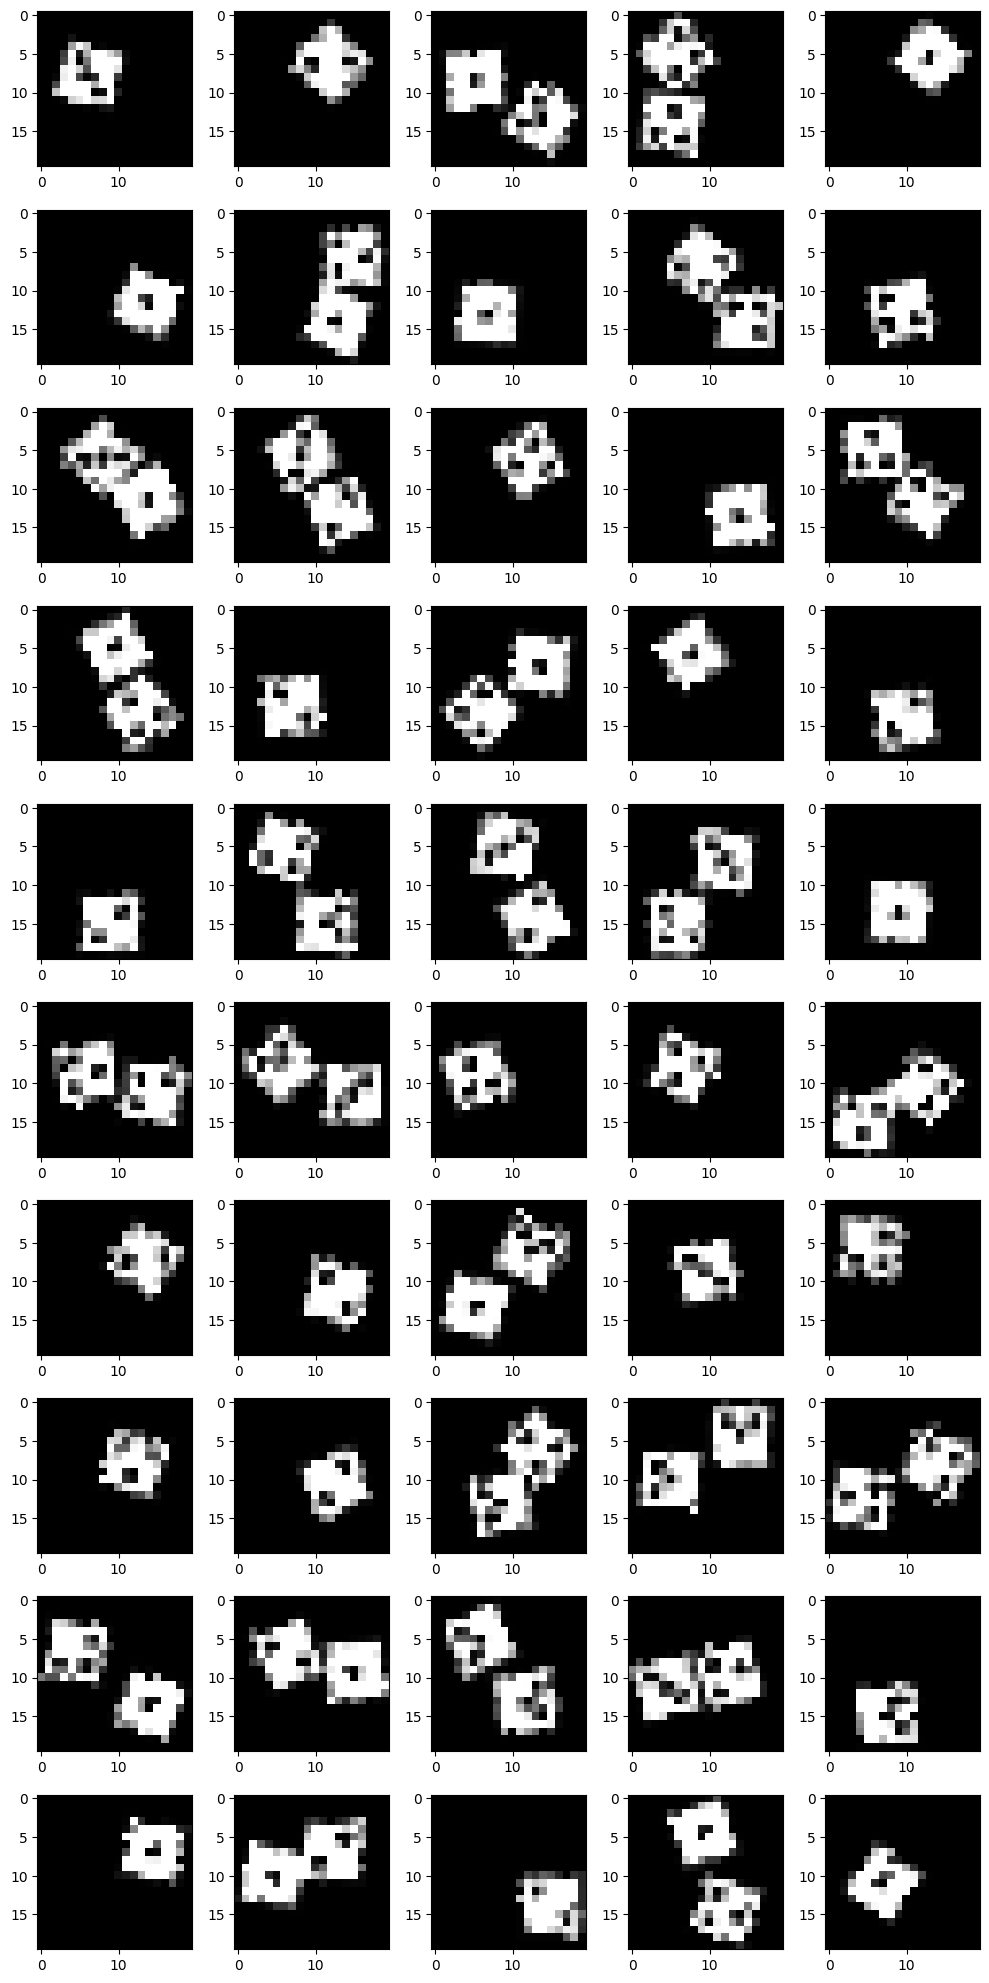

In [6]:
fig = plt.figure(figsize=(10, 10*((n//5)/5)))
for cnt, i in enumerate(range(n)):
    ax = fig.add_subplot(n//5, 5, cnt+1)
    plt.imshow(X_train[i, :], cmap='gray')
    plt.tight_layout()

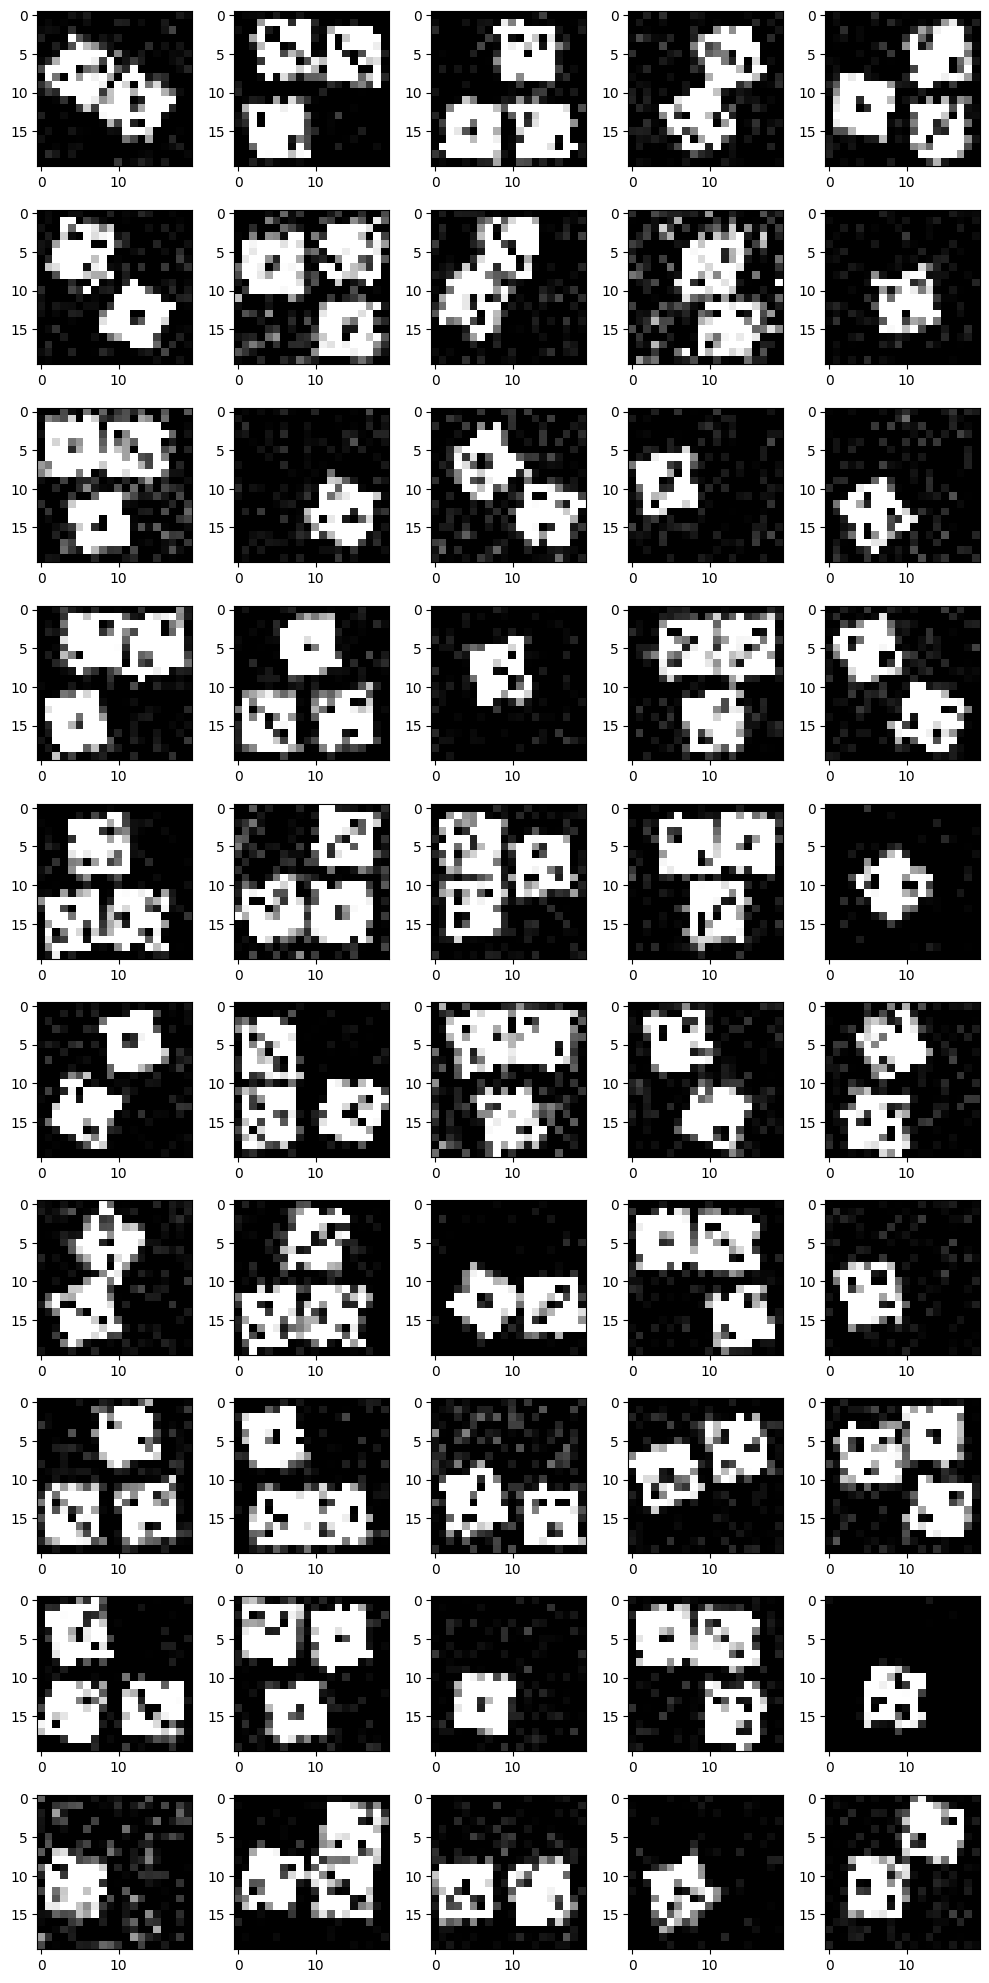

In [7]:
fig = plt.figure(figsize=(10, 10*((n//5)/5)))
for cnt, i in enumerate(range(n)):
    ax = fig.add_subplot(n//5, 5, cnt+1)
    plt.imshow(X_test[i, :], cmap='gray')
    plt.tight_layout()

### Resizeと二値化

In [7]:
imgs = X_train[:n, :]

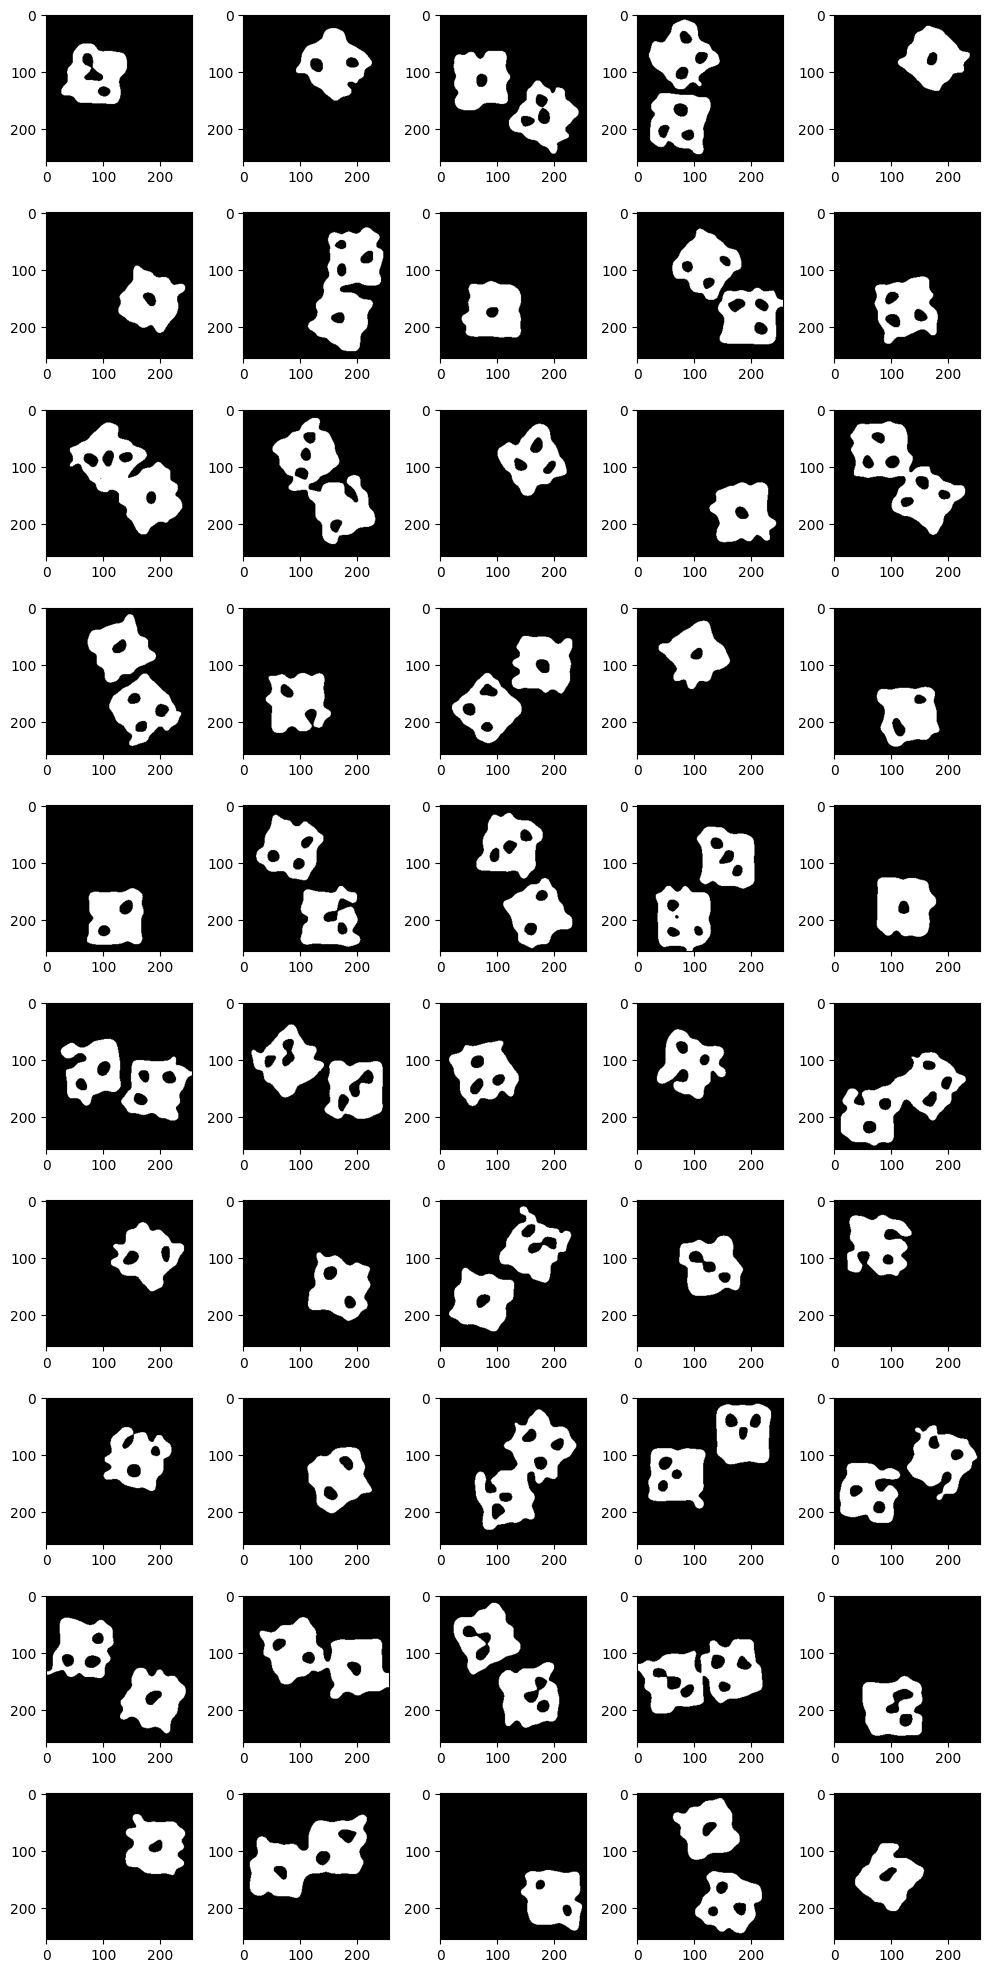

In [8]:
fig = plt.figure(figsize=(10, 10*((n//5)/5)))
imgs_bi = np.ones((n, 256, 256), dtype='uint8')
for i, img in enumerate(imgs):
    # resize ランチョス
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # 2値化 大津
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # # closing
    # kernel_1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_1, iterations=3)
    # kernel_2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_2, iterations=1)

    imgs_bi[i, :] = img

    # show image
    ax = fig.add_subplot(n//5, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.tight_layout()

### 輪郭と矩形検知

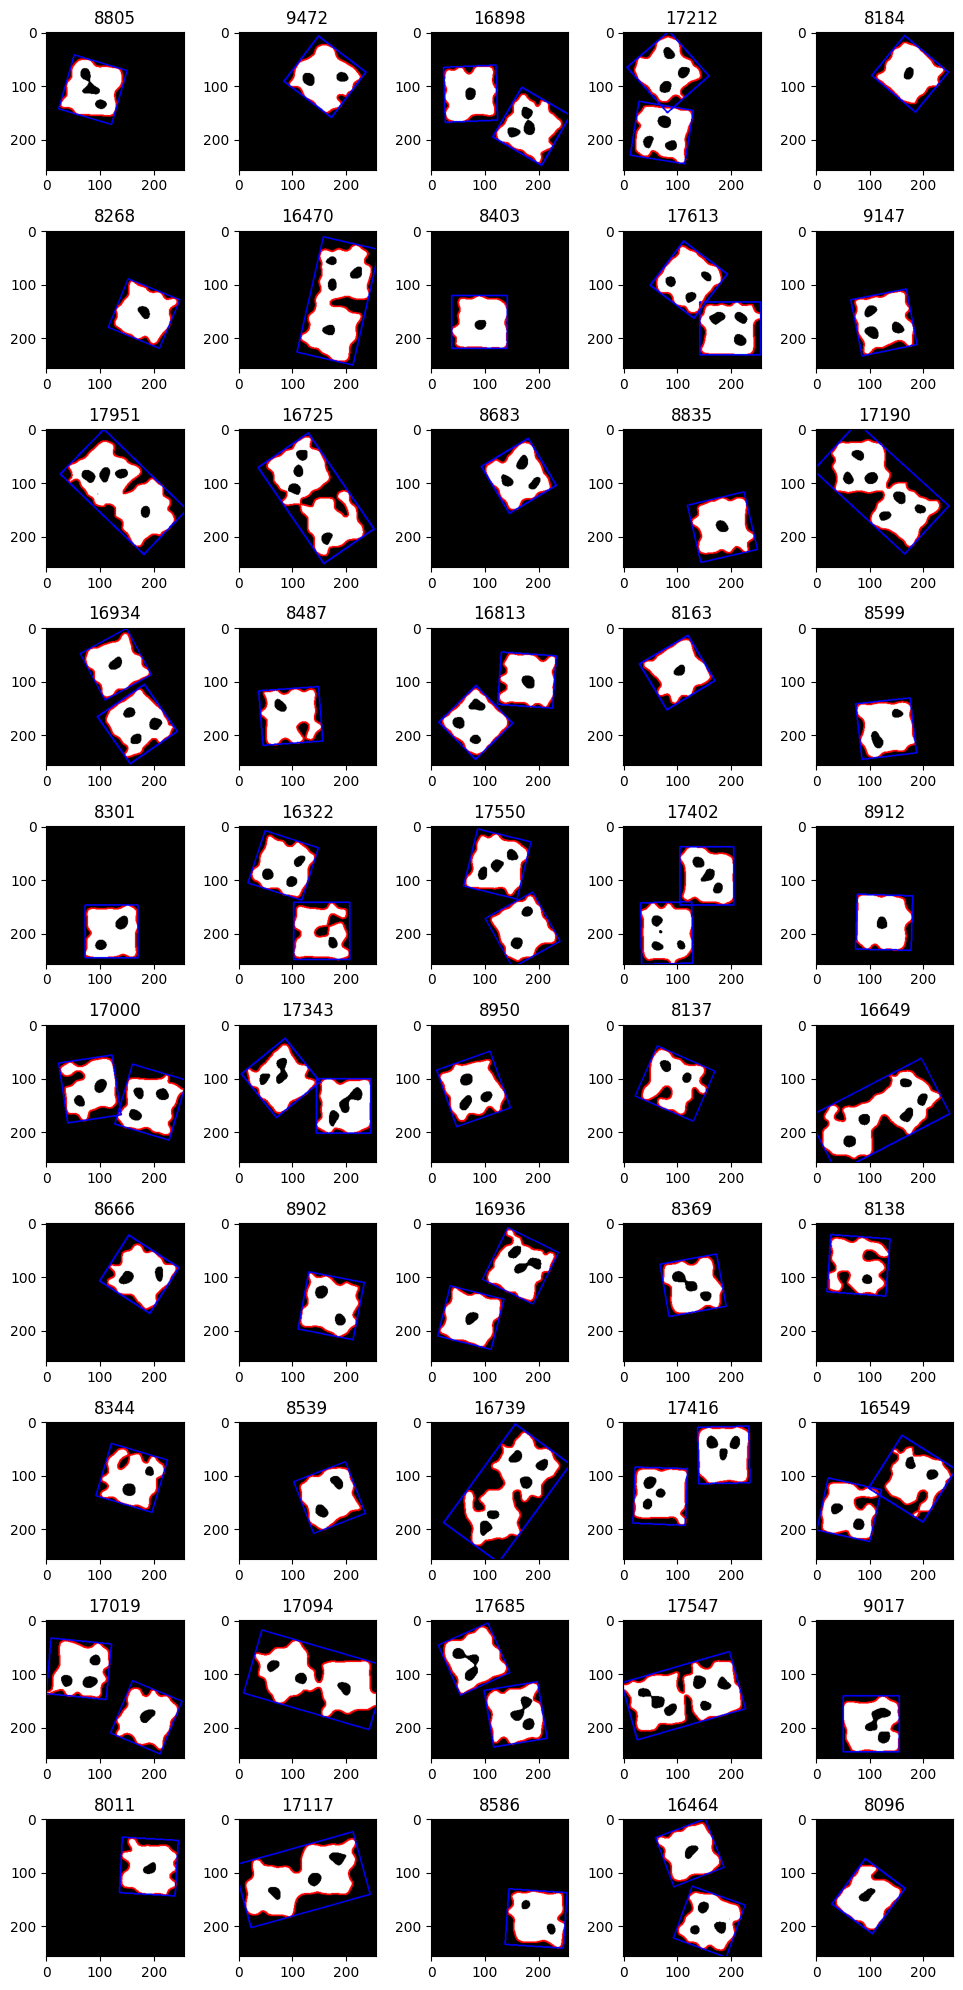

In [76]:
fig = plt.figure(figsize=(10, 10*((n//5)/5)))

for i in range(n):
    contours, hierarchy = cv2.findContours(image=imgs_bi[i, :], # lanczosを使う
                                           mode=cv2.RETR_EXTERNAL, # 一番外側の輪郭のみ
                                           method=cv2.CHAIN_APPROX_SIMPLE) # 輪郭座標の詳細なし

    # 表示用にカラーデータに変換する
    img_disp = cv2.cvtColor(imgs_bi[i, :], cv2.COLOR_GRAY2BGR)

    # dice_area = []

    # 輪郭の描写
    for j, contour in enumerate(contours):
        # 輪郭を描画
        cv2.drawContours(img_disp, contours, j, (255, 0, 0), 2)

        # 面積の算出
        # tmp_area = cv2.contourArea(contour)
        # dice_area.append(tmp_area)

        # 傾いた外接する矩形領域
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(img_disp, [box], 0, (0,0,255), 2)

    # 画像の表示
    ax = fig.add_subplot(n//5, 5, i+1)
    plt.imshow(img_disp, cmap='gray')
    # plt.title(int(sum(dice_area)))
    plt.tight_layout()

In [8]:
rect_centers = []
rect_sizes = []
rect_areas = []
one_dice_idx = []

for i in range(X_train.shape[0]):
    img = X_train[i, :]
    
    # resize ランチョス
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # 2値化 otsu
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # closing
    # kernel_1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_1, iterations=3)
    # kernel_2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_2, iterations=1)
    
    rect_center, rect_size, rect_angle, rect_sum_area = getRect(img)

    rect_areas.append(rect_sum_area)

    # もし画像内のサイコロの面積が閾値を超えていたら画像は考えないとする場合
    if rect_sum_area > 12000:
        continue

    one_dice_idx.append(i)

    rect_centers += rect_center 
    rect_sizes += rect_size

Text(0.5, 1.0, 'distribution of dice (left: one, right: two)')

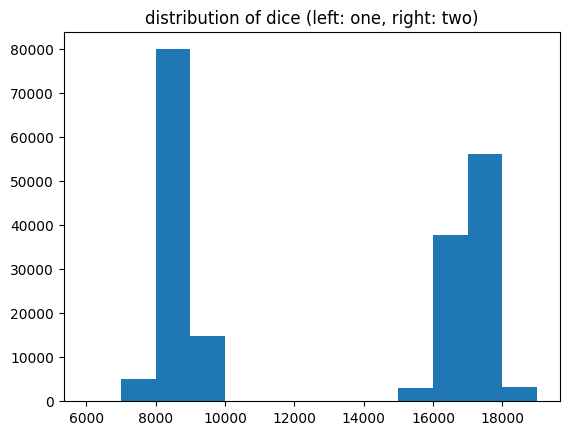

In [11]:
# 面積の分布
plt.hist(rect_areas, bins=range(6000, 20000, 1000))
plt.title('distribution of dice (left: one, right: two)')

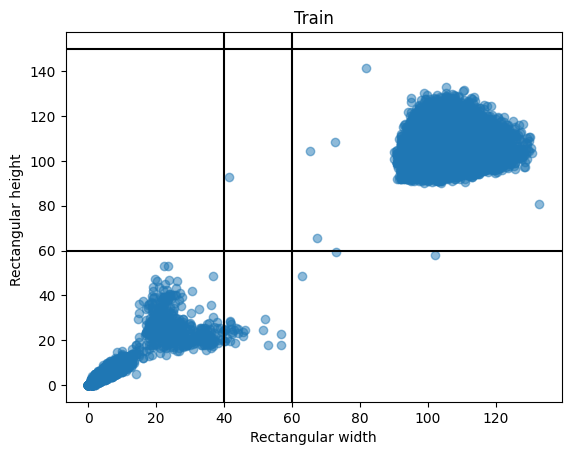

In [12]:
# 矩形形状の分布の確認
width = [rect_size[0] for rect_size in rect_sizes]
height = [rect_size[1] for rect_size in rect_sizes]

fig, ax = plt.subplots()
ax.axhline(y=60, color='k')
ax.axhline(y=150, color='k')
ax.axvline(x=40, color='k')
ax.axvline(x=60, color='k')
plt.scatter(width, height, alpha=0.5)
plt.xlabel('Rectangular width')
plt.ylabel('Rectangular height ')
plt.title('Train')
plt.show()

##### サイコロ一つしかない対象に思いっきりクロージング
サイコロの目は消えるが離れている対象に連結してくれるはず

In [25]:
rect_centers = []
rect_sizes = []
# closingされたimgの格納リスト
rect_list = []
have_small_piece_idx = []
have_small_piece_rect = []

for i, idx in enumerate(one_dice_idx):
    # サイコロを一つしか持たない画像
    img = X_train[idx, :]
    
    # resize lanczos
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # 2値化 otsu
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # closing
    kernel_1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_1, iterations=5)

    contours, hierarchy = cv2.findContours(image=img, # lanczosを使う
                                           mode=cv2.RETR_EXTERNAL, # 一番外側の輪郭のみ
                                           method=cv2.CHAIN_APPROX_SIMPLE) # 輪郭座標の詳細なし
    tmp_list = []
    have_small_piece = False

    for cnt, contour in enumerate(contours):
        
        # 傾いた外接する矩形領域
        rect = cv2.minAreaRect(contour)

        if (80 <= rect[1][0] <= 150) and (80 <= rect[1][1] <= 150):
            rect_list.append(rect)
            tmp_list.append(cnt)
        else:
            have_small_piece = True
    
    if have_small_piece:
        have_small_piece_idx.append(idx)
        have_small_piece_rect.append(rect_list[-1])
        have_small_piece = False
            
    assert len(tmp_list) == 1

print(len(rect_list))

99886


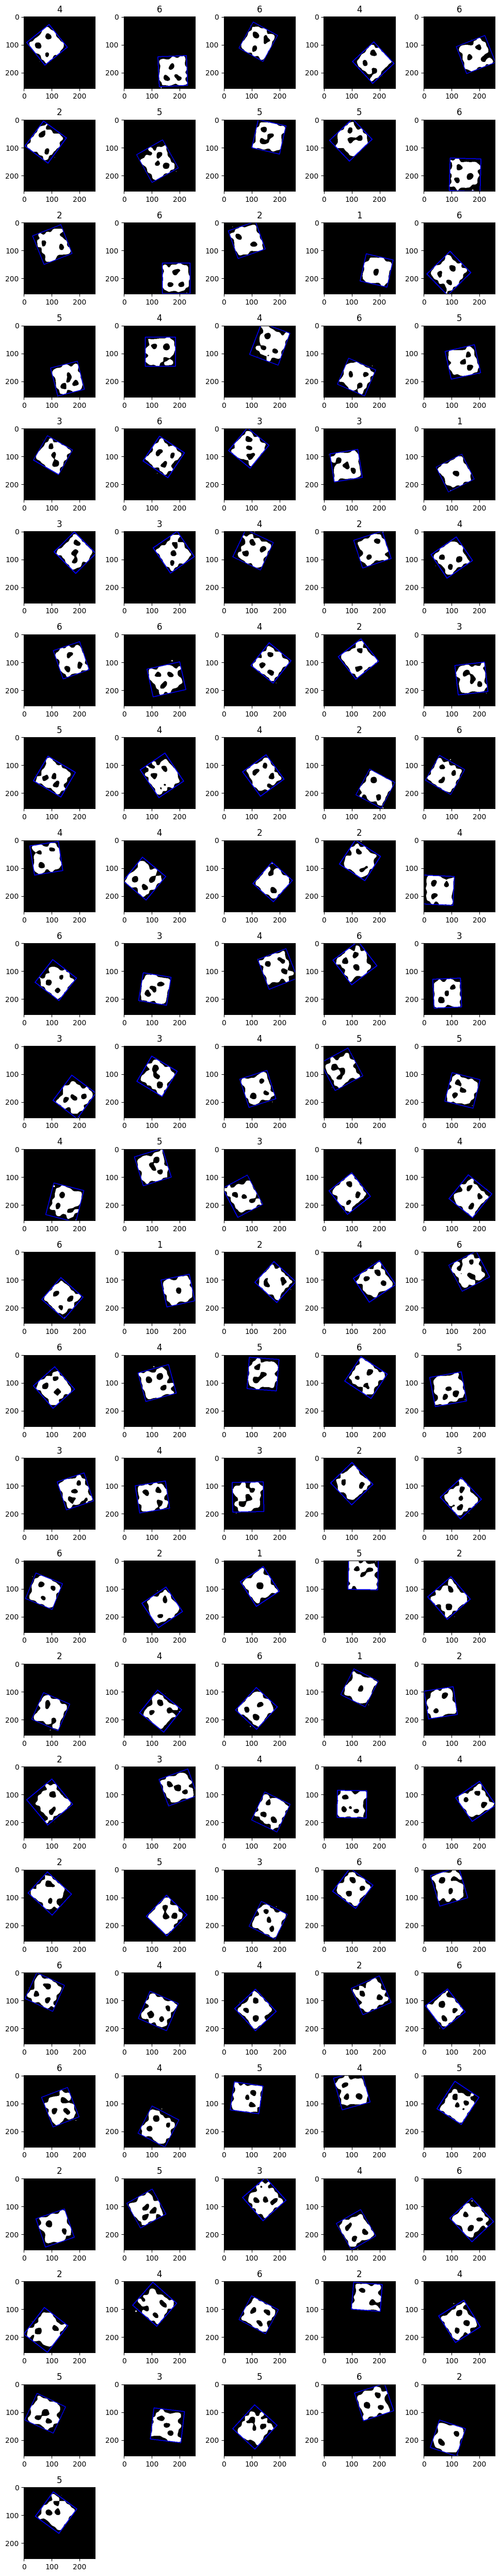

In [31]:
fig = plt.figure(figsize=(10, 10*((len(have_small_piece_rect)//5+1)/5)))

for i in range(len(have_small_piece_rect)):
    img = X_train[have_small_piece_idx[i], :]

    # resize lanczos
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # 2値化 otsu
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 表示用にカラーデータに変換する
    img_disp = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # 傾いた外接する矩形領域
    rect = have_small_piece_rect[i]
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    cv2.drawContours(img_disp, [box], 0, (0,0,255), 2)

    # 画像の表示
    ax = fig.add_subplot(len(have_small_piece_rect)//5+1, 5, i+1)
    plt.imshow(img_disp, cmap='gray')
    plt.title(y_train[have_small_piece_idx[i]])
    plt.tight_layout()

##### 検証データ

In [50]:
rect_centers_test = []
rect_sizes_test = []

for i in range(X_test.shape[0]):
    img = X_test[i, :]
    
    # resize ランチョス
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # 2値化 otsu
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    rect_center_test, rect_size_test, rect_angle = getRect(img)

    rect_centers_test += rect_center_test 
    rect_sizes_test += rect_size_test

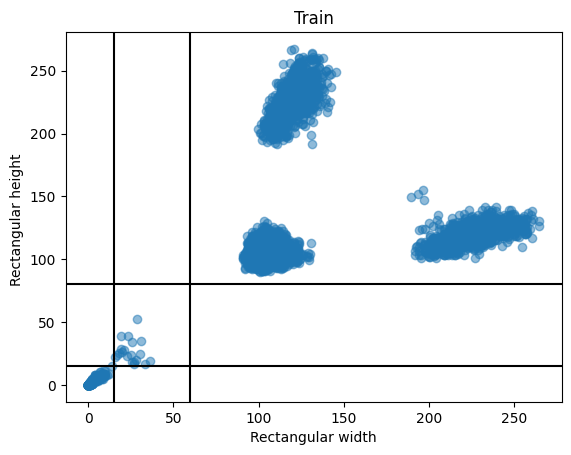

In [51]:
# 矩形形状の分布の確認
width = [rect_size[0] for rect_size in rect_sizes_test]
height = [rect_size[1] for rect_size in rect_sizes_test]

fig, ax = plt.subplots()
ax.axhline(y=15, color='k')
ax.axhline(y=80, color='k')
ax.axvline(x=15, color='k')
ax.axvline(x=60, color='k')
plt.scatter(width, height, alpha=0.5)
plt.xlabel('Rectangular width')
plt.ylabel('Rectangular height ')
plt.title('Train')
plt.show()

##### 小さい長細い要素を持つデータを調べる
2値化の時点で完全に割れてしまい小さい片割れができた矩形領域が存在すると思われる

In [48]:
# 長細い矩形を持つ画像のindex
idx_list = []

for i in range(X_train.shape[0]):

    img = X_train[i, :]
    
    # resize and binarization 
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    _, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    rect_center, rect_size, rect_angle = getRect(img)
    # サイコロのrect情報を格納するリスト
    dice_rect = []
    for j, size_tmp in enumerate(rect_size):
        # if ((size_tmp[0] < 85) and (60 <= size_tmp[1] <= 150)) or ((size_tmp[1] < 85) and (60 <= size_tmp[0] <= 150)):
        # if (size_tmp[1] < 60) and (40 <= size_tmp[0] <= 60):
        if (15< (size_tmp[0] < 60) and (15 <= size_tmp[1] <= 80)):
            idx_list.append(i)

print(len(idx_list))

0


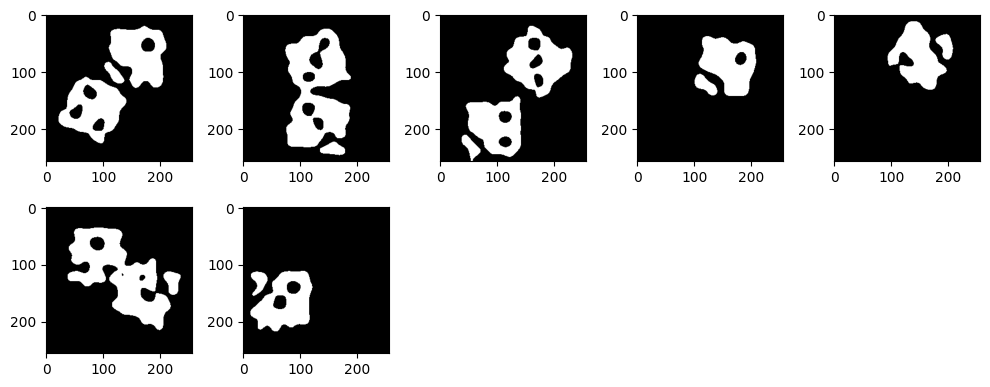

In [43]:
img_num = len(idx_list)

fig = plt.figure(figsize=(10, 10*((img_num//5+1)/5)))
imgs_unusual_bi = np.ones((img_num, 256, 256), dtype='uint8')
for cnt, i in enumerate(idx_list):
    img = X_train[i, :]
    # resize ランチョス
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # 2値化 大津
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    imgs_unusual_bi[cnt, :] = img

    # show image
    ax = fig.add_subplot((img_num//5) + 1, 5, cnt+1)
    plt.imshow(img, cmap='gray')
    plt.tight_layout()

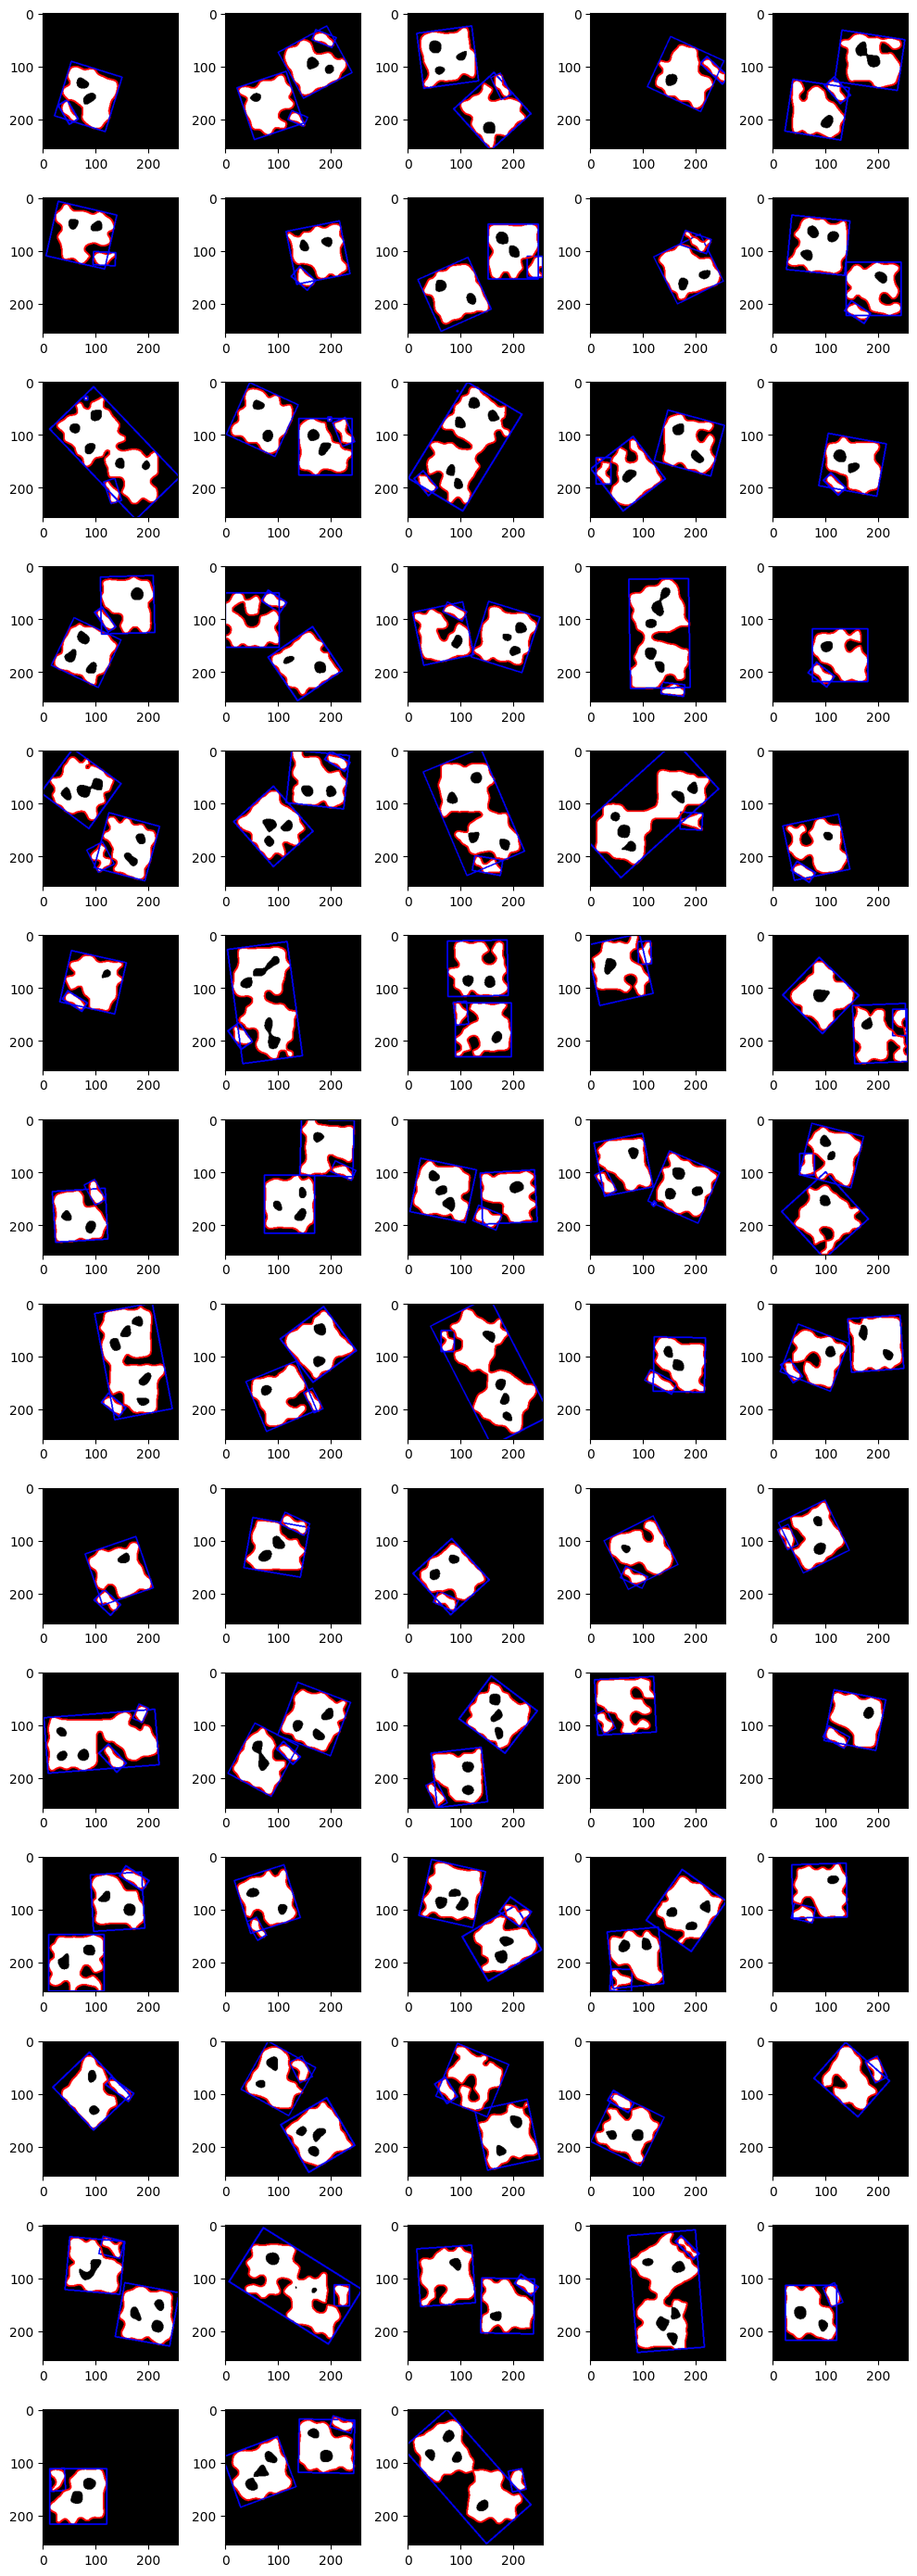

In [16]:
fig = plt.figure(figsize=(10, 10*((img_num//5+1)/5)))

for cnt, i in enumerate(range(len(idx_list))):
    contours, hierarchy = cv2.findContours(image=imgs_unusual_bi[i, :], # lanczosを使う
                                           mode=cv2.RETR_EXTERNAL, # 一番外側の輪郭のみ
                                           method=cv2.CHAIN_APPROX_SIMPLE) # 輪郭座標の詳細なし

    # 表示用にカラーデータに変換する
    img_disp = cv2.cvtColor(imgs_unusual_bi[i, :], cv2.COLOR_GRAY2BGR)

    # 輪郭の描写
    for j, contour in enumerate(contours):
        # 輪郭を描画
        cv2.drawContours(img_disp, contours, j, (255, 0, 0), 2)

        # 傾いた外接する矩形領域
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(img_disp, [box], 0, (0,0,255), 2)

    # 画像の表示
    ax = fig.add_subplot(img_num//5+1, 5, cnt+1)
    plt.imshow(img_disp, cmap='gray')
    plt.tight_layout()

### データの選定 ver1
* 一つだけサイコロが存在する画像からサイコロの矩形領域を切り出して目の数を学習する
* 面積を考えることで2つサイコロが存在する画像を排除することができるためそっちを利用する

In [ ]:
imgs, labels, labels_unexp, labels_undetect = getOneDiceImageInfoListFromRecWidth()

In [8]:
print(f'サイコロを一つしか持たない画像の数: {len(imgs)}')
print(f'ラベルの数: {len(labels)}')

サイコロを一つしか持たない画像の数: 99885
ラベルの数: 99885


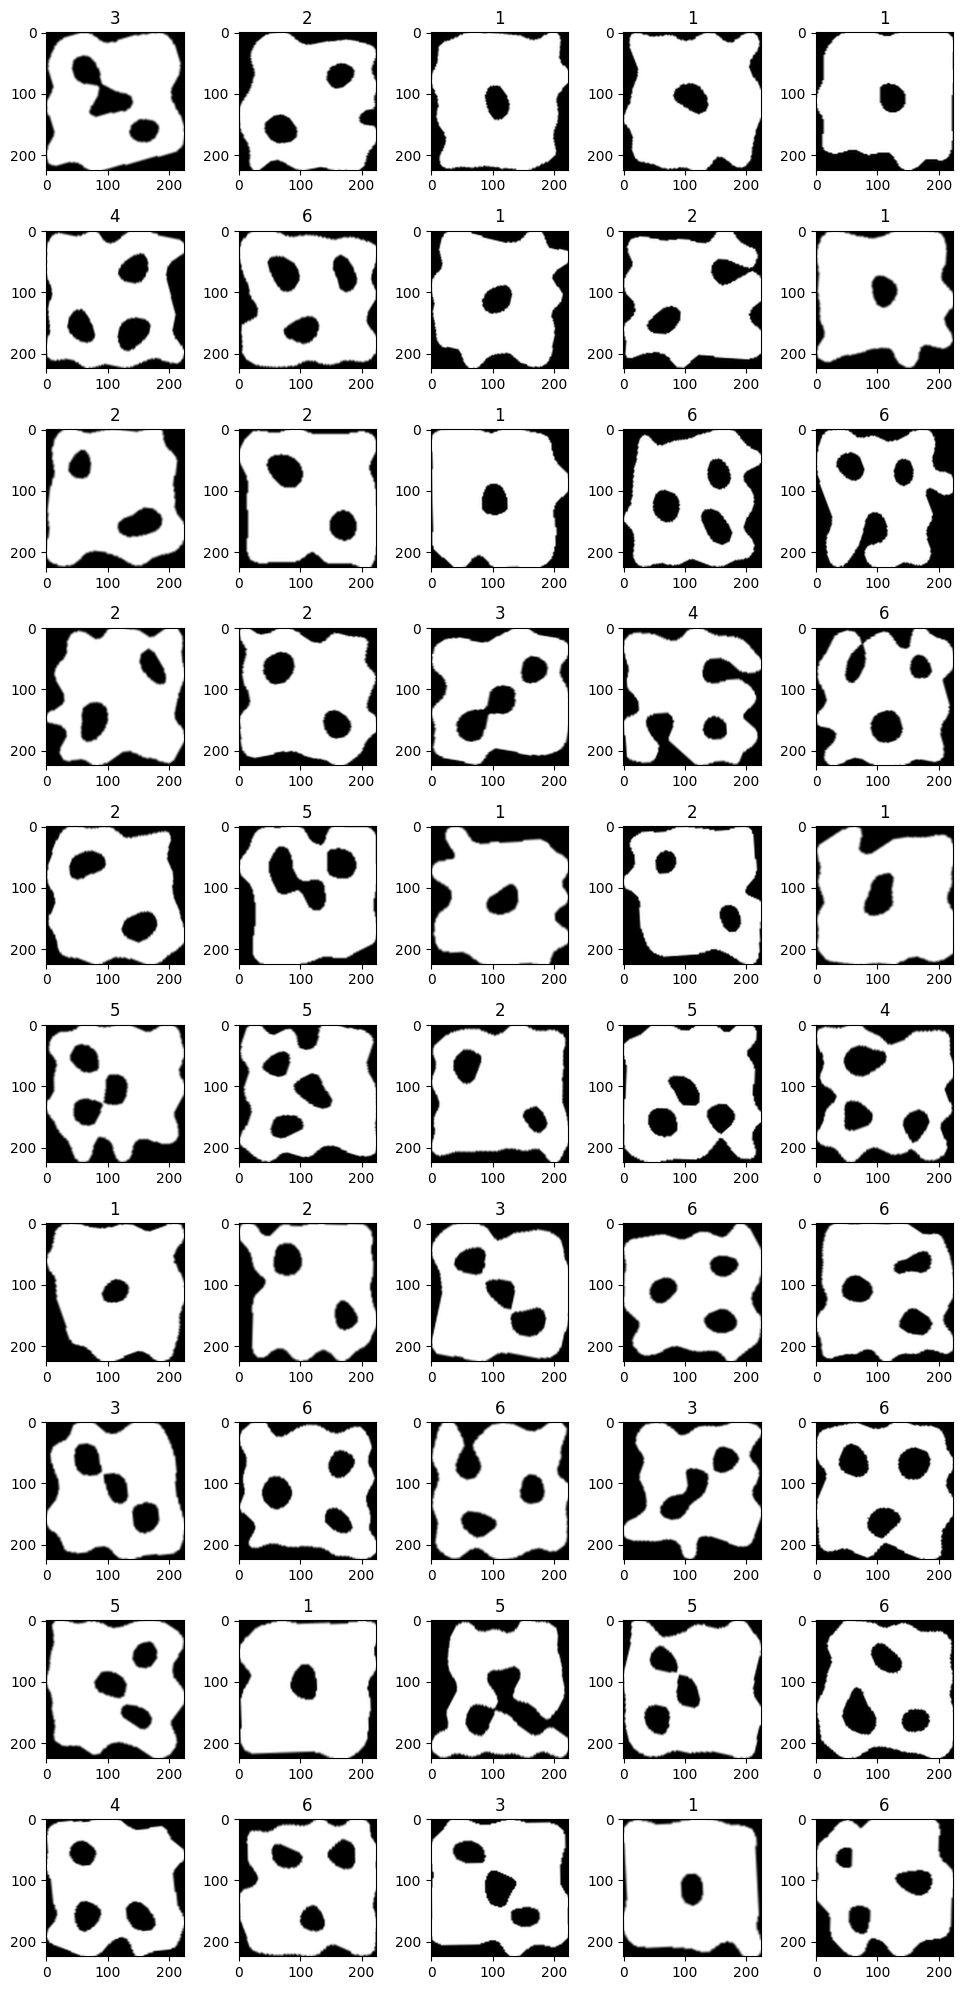

In [19]:
# 可視化
fig = plt.figure(figsize=(10, 10*((n//5)/5)))
for i in range(n):
    ax = fig.add_subplot(n//5, 5, i+1)
    plt.imshow(imgs[i], cmap='gray')
    plt.title(labels[i])
    plt.tight_layout()

##### 想定通りにならなかったものを可視化
本来ならサイコロの数は一つなのでラベルは1-6のはずが6を超えてしまった対象

In [9]:
print('想定通りにならなかった画像のインデックス: {}'.format(labels_unexp))

想定通りにならなかった画像のインデックス: [5624, 11239, 31095, 60173, 64111, 79621, 90416, 110545, 155519]


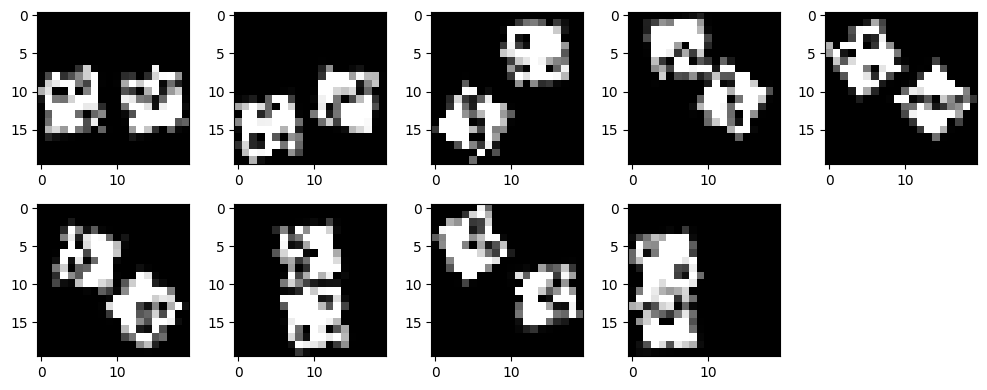

In [21]:
fig = plt.figure(figsize=(10, 10*((10//5)/5)))
for cnt, i in enumerate(labels_unexp):
    ax = fig.add_subplot(10//5, 5, cnt+1)
    plt.imshow(X_train[i, :], cmap='gray')
    plt.tight_layout()

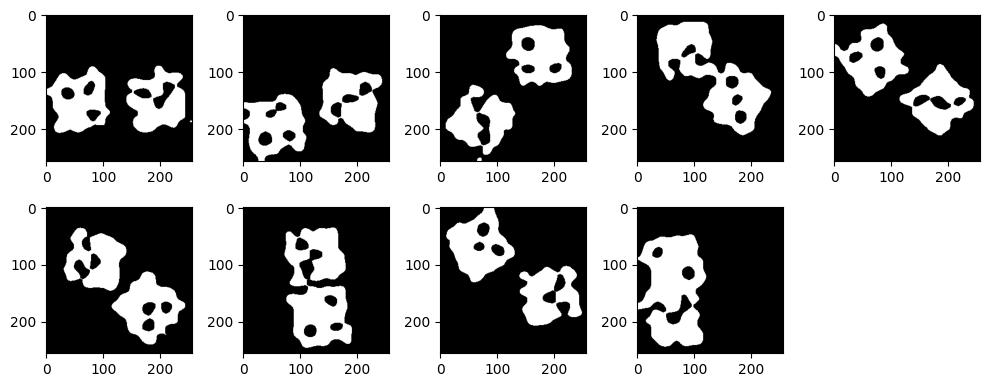

In [38]:
fig = plt.figure(figsize=(10, 10*((10//5)/5)))
imgs_bi = np.ones((len(labels_unexp), 256, 256), dtype='uint8')
for i, idx in enumerate(labels_unexp):
    img = X_train[idx, :]
    # resize ランチョス
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # 2値化 大津
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)

    imgs_bi[i, :] = img

    # show image
    ax = fig.add_subplot(10//5, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.tight_layout()

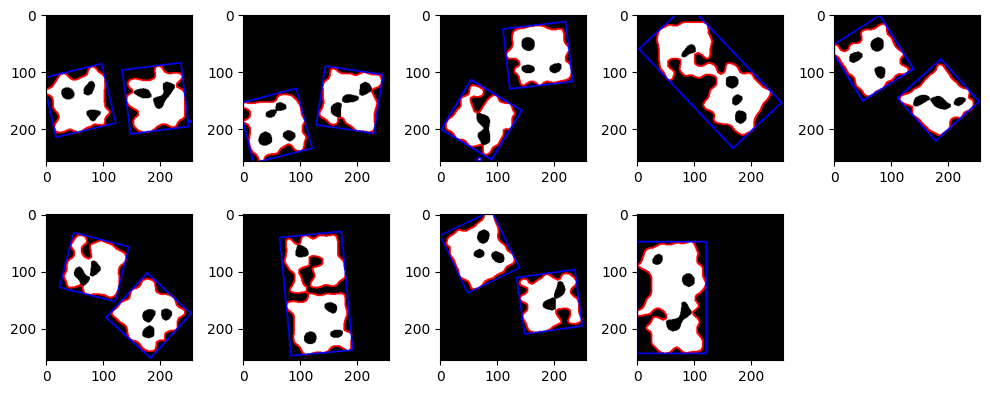

In [24]:
fig = plt.figure(figsize=(10, 10*((n//5)/5)))

for i in range(9):
    contours, hierarchy = cv2.findContours(image=imgs_bi[i, :], # lanczosを使う
                                           mode=cv2.RETR_EXTERNAL, # 一番外側の輪郭のみ
                                           method=cv2.CHAIN_APPROX_SIMPLE) # 輪郭座標の詳細なし

    # 表示用にカラーデータに変換する
    img_disp = cv2.cvtColor(imgs_bi[i, :], cv2.COLOR_GRAY2BGR)

    # 輪郭の描写
    for j, contour in enumerate(contours):
        # 輪郭を描画
        cv2.drawContours(img_disp, contours, j, (255, 0, 0), 2)

        # 傾いた外接する矩形領域
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(img_disp, [box], 0, (0,0,255), 2)

    # 画像の表示
    ax = fig.add_subplot(n//5, 5, i+1)
    plt.imshow(img_disp, cmap='gray')
    plt.tight_layout()

### 2つのサイコロを別々に分解
spectral clustering を用いて2つのサイコロを分解する

##### 訓練データ

In [5]:
# # 訓練データ
# # サイコロを一つだけ持つ画像のindexを取得
# one_dice_idx, _, _ = getOneDiceImageInfoListFromArea(data_type='train')

# two_dice_idx = []
# cnt = 0

# for i in range(len(X_train)):
#     if i == one_dice_idx[cnt]:
#         if i < one_dice_idx[-1]:
#             cnt += 1
#     else:
#         two_dice_idx.append(i)

In [6]:
# print('one dice index の長さ: {}'.format(len(one_dice_idx)))

one dice index の長さ: 99886


In [7]:
# print('one dice index の長さとtwo dice index の長さの和: {}'.format(len(one_dice_idx) + len(two_dice_idx)))

one dice index の長さとtwo dice index の長さの和: 200000


##### テストデータ

In [74]:
# テストデータ
one_dice_idx_test, one_dice_imgs_test, _ = getOneDiceImageInfoListFromArea('test')

two_dice_idx_test = []
cnt = 0

for i in range(len(X_test)):
    if i == one_dice_idx_test[cnt]:
        if i < one_dice_idx_test[-1]:
            cnt += 1
    else:
        two_dice_idx_test.append(i)

In [75]:
len(one_dice_idx_test) + len(two_dice_idx_test)

10000

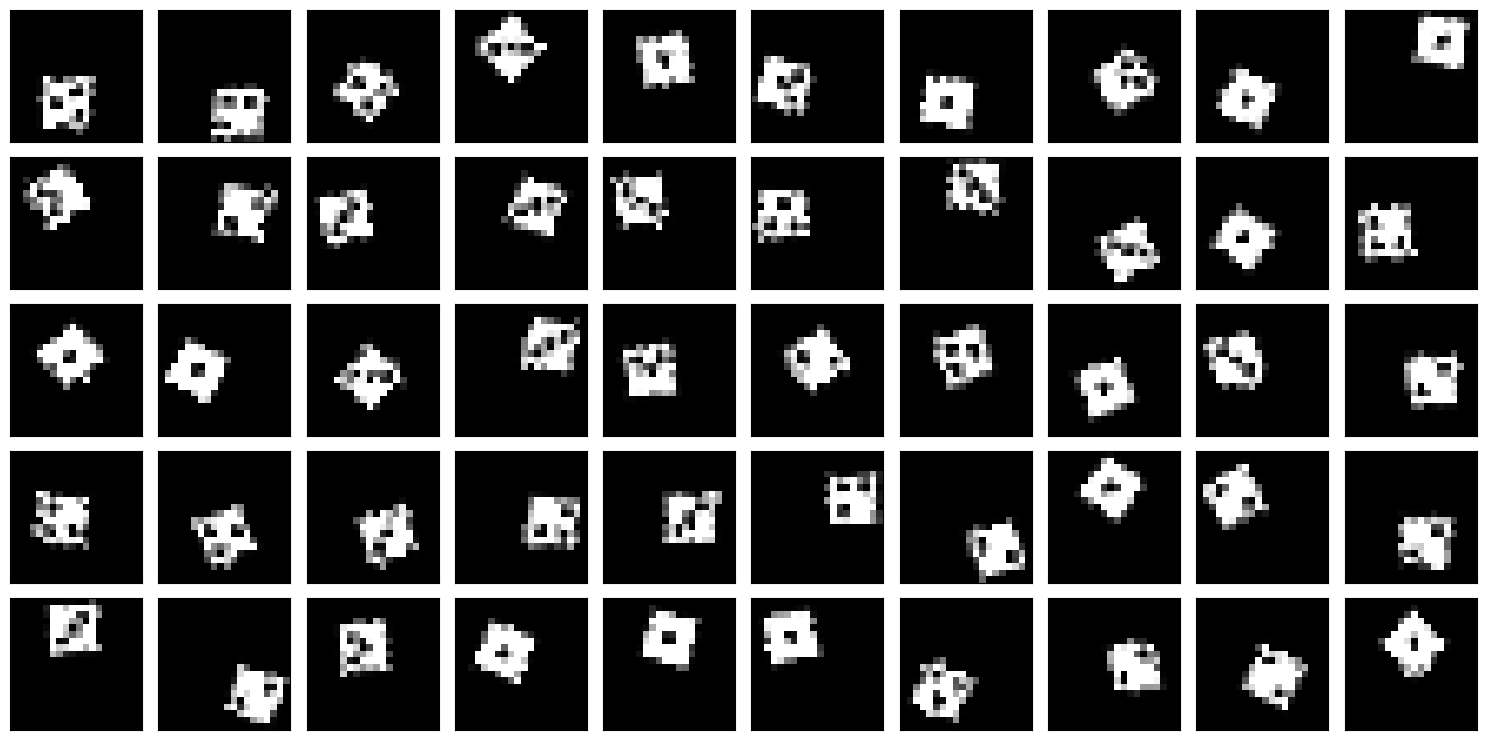

In [29]:
# サイコロが一つの時
# n = 50
fig = plt.figure(figsize=(15, 15*((n//10)/10)))

for cnt, i in enumerate(one_dice_idx_test[:n]):
    ax = fig.add_subplot(n//10, 10, cnt+1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(X_test[i, :], cmap='gray')
    plt.tight_layout()

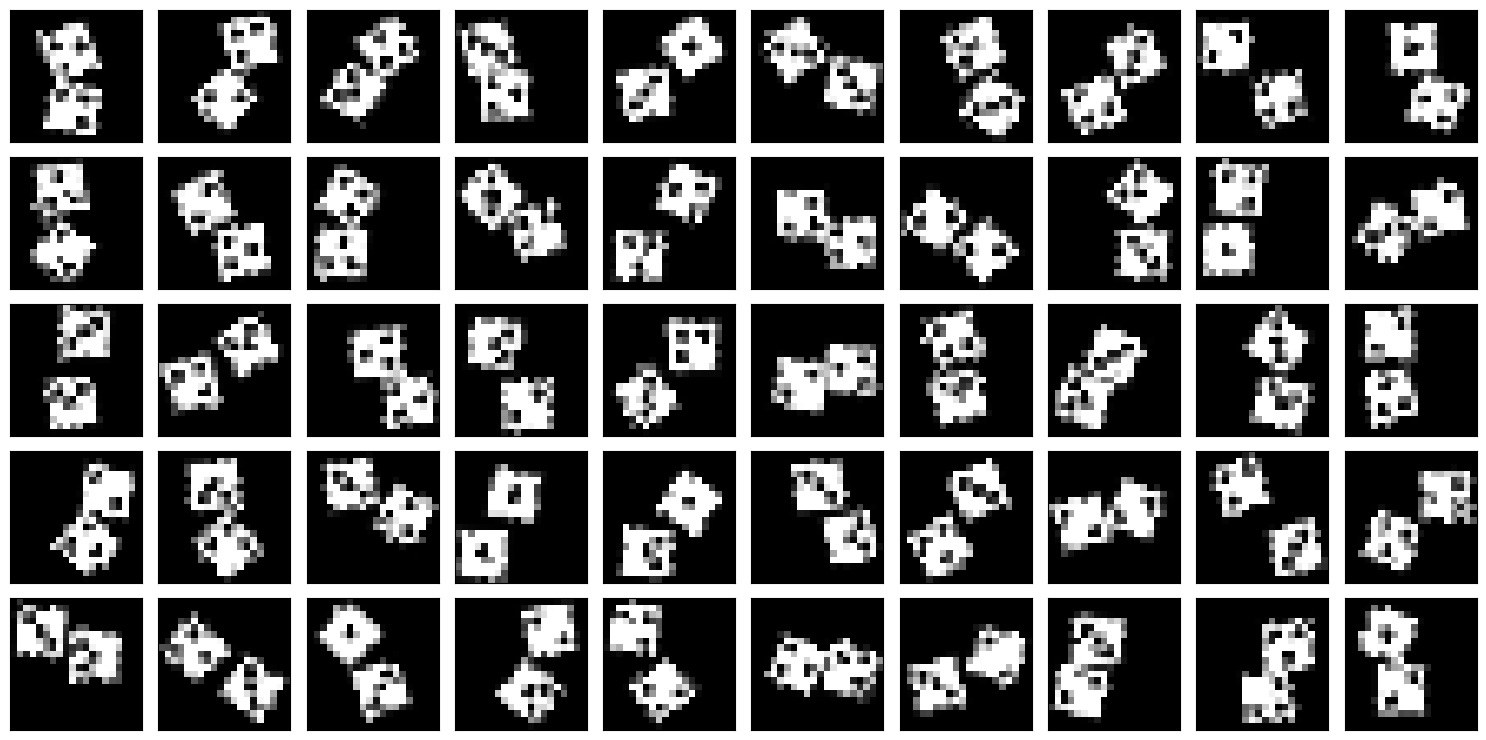

In [30]:
# サイコロが二つの時
# n = 50
fig = plt.figure(figsize=(15, 15*((n//10)/10)))

for cnt, i in enumerate(two_dice_idx_test[:n]):
    ax = fig.add_subplot(n//10, 10, cnt+1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(X_test[i, :], cmap='gray')
    plt.tight_layout()

##### Spectral Clustering
クラスタの中心と広がりの尺度が，クラスタが2次元平面上の入れ子円である場合など，完全なクラスタの記述として適切でない場合に，スペクトル・クラスタリングは非常に有用である

In [44]:
from sklearn.cluster import SpectralClustering

Text(0.5, 1.0, 'sample two dice image')

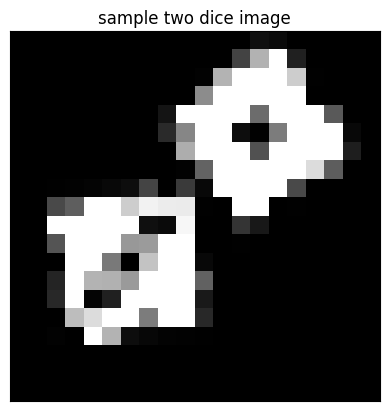

In [45]:
img_sample = X_test[two_dice_idx_test[4], :]
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.imshow(img_sample, cmap='gray')
plt.title('sample two dice image')

In [46]:
# 輝度地が10以上であればそこにサイコロを構成するピクセルがあると考える
dice_pix = []
for i in range(20):
    for j in range(20):
        if img_sample[i, j] >= 10:
            dice_pix.append([i, j])
dice_pix = np.array(dice_pix)
print(dice_pix.shape)

(124, 2)


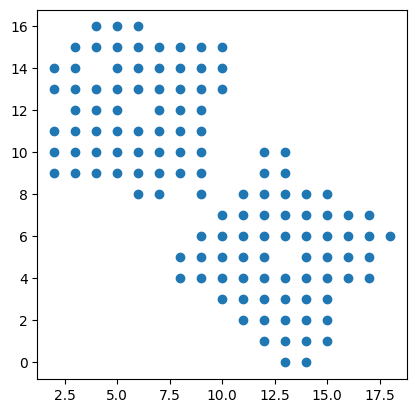

In [47]:
g = plt.subplot()
plt.scatter(dice_pix[:, 1], dice_pix[:, 0])
g.set_aspect('equal')

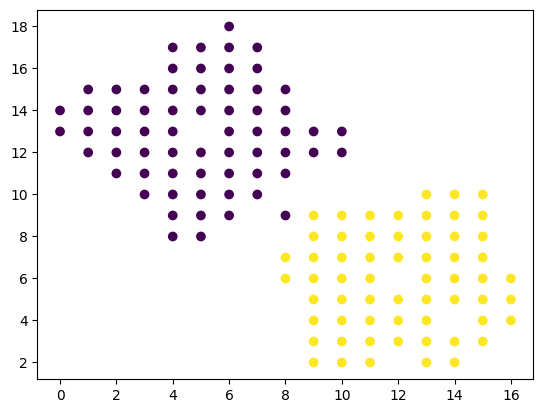

In [48]:
# affinity = nearest_neightbors でうまく可視化できてる
clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0, affinity='nearest_neighbors').fit(dice_pix)
# print(clustering.labels_)
plt.scatter(dice_pix[:,0],dice_pix[:,1], c=clustering.labels_)

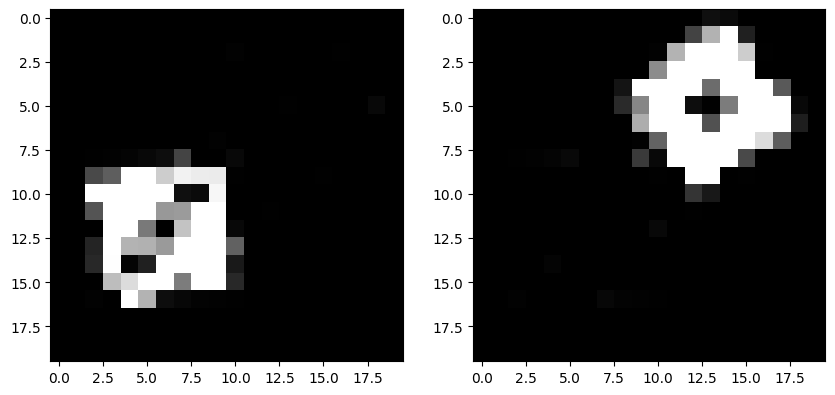

In [49]:
fig = plt.figure(figsize=(10, 5))
img_sample_copy = img_sample.copy()

for i, [x, y] in enumerate(dice_pix):
    label = clustering.labels_[i]
    if label == 0:
        img_sample_copy[x, y] = 1

ax = fig.add_subplot(1, 2, 1)
plt.imshow(img_sample_copy, cmap='gray')

img_sample_copy = img_sample.copy()
for i, [x, y] in enumerate(dice_pix):
    label = clustering.labels_[i]
    if label == 1:
        img_sample_copy[x, y] = 1

ax = fig.add_subplot(1, 2, 2)
plt.imshow(img_sample_copy, cmap='gray')

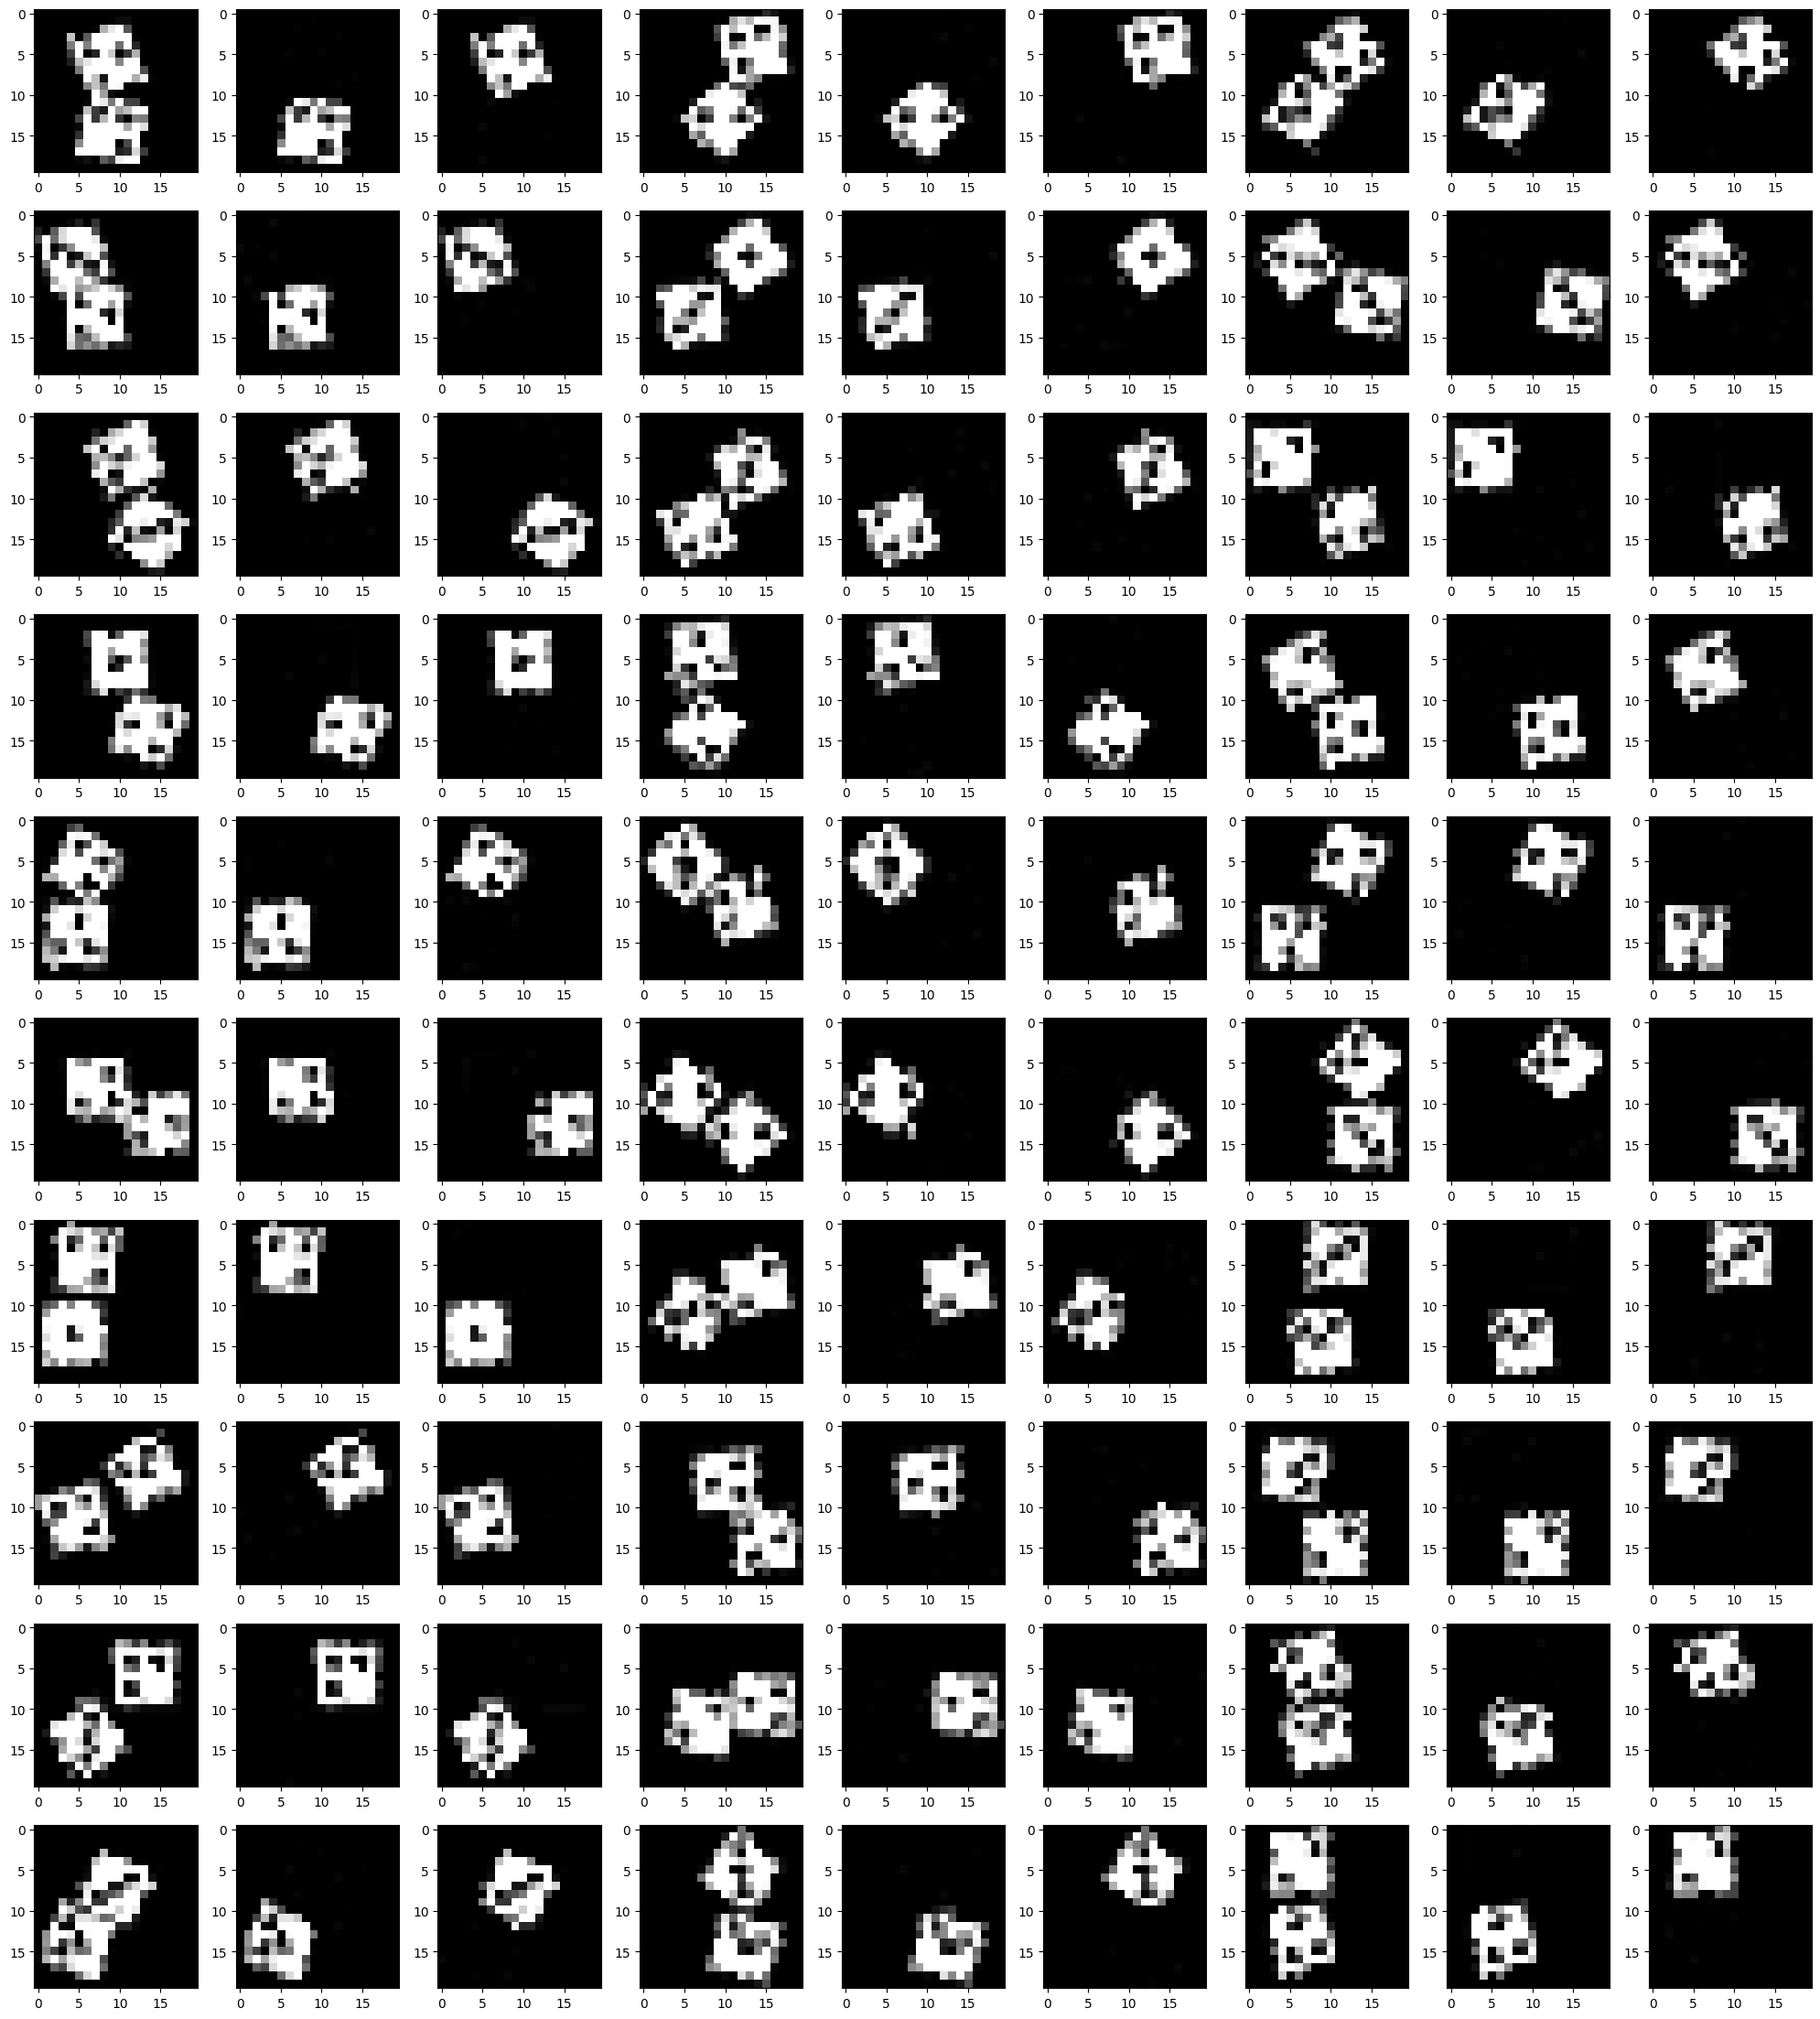

In [67]:
# 複数枚の画像で確認

n = 90
fig = plt.figure(figsize=(20, 20*n//9/9))

for cnt, i in enumerate(two_dice_idx_test[:(n//3)]):
    img = X_test[i, :]

    dice_pix = []
    for j in range(20):
        for k in range(20):
            if img[j, k] >= 10:
                dice_pix.append([j, k])
    dice_pix = np.array(dice_pix)

    ax = fig.add_subplot(n//9, 9, int(3*cnt+1))
    plt.imshow(img, cmap='gray')
    plt.tight_layout()

    # affinity = nearest_neightbors でうまく可視化できてる
    clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0, affinity='nearest_neighbors').fit(dice_pix)
    
    img_copy = img.copy()
    for m, [x, y] in enumerate(dice_pix):
        label = clustering.labels_[m]
        if label == 0:
            img_copy[x, y] = 1

    ax = fig.add_subplot(n//9, 9, int(3*cnt+2))
    plt.imshow(img_copy, cmap='gray')
    plt.tight_layout()

    img_copy = img.copy()
    for l, [x, y] in enumerate(dice_pix):
        label = clustering.labels_[l]
        if label == 1:
            img_copy[x, y] = 1

    ax = fig.add_subplot(n//9, 9, int(3*cnt+3))
    plt.imshow(img_copy, cmap='gray')
    plt.tight_layout()

### サイコロの数が3つに更新されたのでその確認 2023/10/27

In [16]:
X_test_renew = np.load('/mnt/c/Users/user/MyData/SonyDice/X_test_renew.npy')
X_test_renew = np.reshape(X_test_renew, [-1, 20, 20])
X_test_renew.shape

(24922, 20, 20)

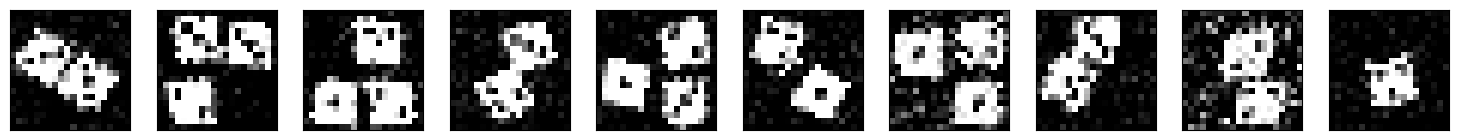

In [6]:
# 生画像の生成
n = 10
fig = plt.figure(figsize=(15, 15*((n//10)/10)))
for i in range(n):
    ax = fig.add_subplot(n//10, 10, i+1)
    plt.imshow(X_test_renew[i, :], cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

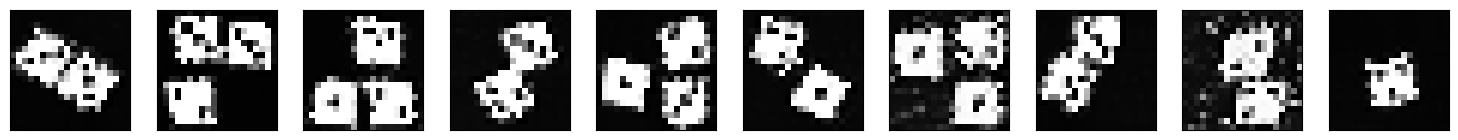

In [7]:
# denoise
imgs_denoise = []
for i, img in enumerate(X_test_renew):
    # resize dinarization
    img = cv2.fastNlMeansDenoising(src=img, h=30, templateWindowSize=3, searchWindowSize=15)
    imgs_denoise.append(img)

n = 10
fig = plt.figure(figsize=(15, 15*((n//10)/10)))
for i in range(n):
    ax = fig.add_subplot(n//10, 10, i+1)
    plt.imshow(imgs_denoise[i], cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

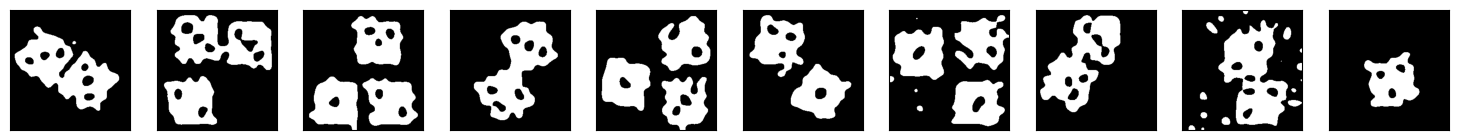

In [131]:
# lanzcos resize + binarization
imgs_bi = []
for i, img in enumerate(X_test_renew):
    # resize dinarization
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    imgs_bi.append(img)

n = 10
fig = plt.figure(figsize=(15, 15*((n//10)/10)))
for i in range(n):
    ax = fig.add_subplot(n//10, 10, i+1)
    plt.imshow(imgs_bi[i], cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

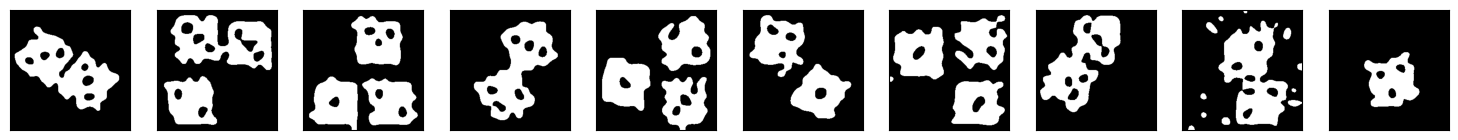

In [136]:
# denoise -> resize -> binarization
imgs_denoise_bi = []
for i, img in enumerate(X_test_renew):
    # resize dinarization
    img = cv2.fastNlMeansDenoising(src=img, h=30, templateWindowSize=3, searchWindowSize=7)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    imgs_denoise_bi.append(img)

n = 10
fig = plt.figure(figsize=(15, 15*((n//10)/10)))
for i in range(n):
    ax = fig.add_subplot(n//10, 10, i+1)
    plt.imshow(imgs_denoise_bi[i], cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

In [8]:
def getRectForEDA(img):
    '''画像に対して矩形領域を検知する関数'''
    contours, _ = cv2.findContours(image=img, 
                                   mode=cv2.RETR_EXTERNAL, # 一番外側の輪郭のみ
                                   method=cv2.CHAIN_APPROX_SIMPLE) # 輪郭座標の詳細なし
    
    rect_center = []
    rect_size = []
    rect_angle = []
    rect_area = []

    for contour in contours:

        # 傾いた外接する矩形領域
        rect = cv2.minAreaRect(contour)
        
        # 検出した矩形の合計面積を求める
        tmp_area = cv2.contourArea(contour)
        # ノイズの閾値よりも面積が大きければ
        if tmp_area > 2500:
            rect_area.append(tmp_area)


        rect_center.append(rect[0])
        rect_size.append(rect[1])
        rect_angle.append(rect[2])
    
    return rect_center, rect_size, rect_angle, int(sum(rect_area))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.100e+01, 1.250e+02, 3.668e+03, 3.609e+03, 1.300e+02, 1.600e+01,
        8.000e+00, 2.000e+00, 7.000e+00, 7.000e+01, 7.230e+02, 3.771e+03,
        1.946e+03, 1.130e+02, 2.700e+01, 1.300e+01, 2.200e+01, 1.100e+02,
        4.960e+02, 2.871e+03, 5.359e+03, 1.692e+03, 1.100e+02, 1.700e+01]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000., 11000., 12000., 13000., 14000., 15000.,
        16000., 17000., 18000., 19000., 20000., 21000., 22000., 23000.,
        24000., 25000., 26000., 27000., 28000., 29000., 30000.]),
 <BarContainer object of 30 artists>)

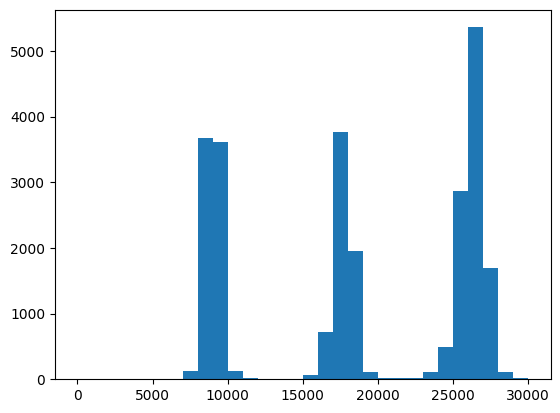

In [12]:
all_area =  []
thres_idx  = []

for i, img in enumerate(X_test_renew):

    # denoise
    img = cv2.fastNlMeansDenoising(src=img, h=30, templateWindowSize=3, searchWindowSize=7)
    # resize
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    # 二値化
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    rect_center, rect_size, rect_angle, rect_area = getRectForEDA(img)

    # for tmp in rect_area:
    #     all_area.append(tmp)

    all_area.append(rect_area)

    if 20000 < rect_area <= 21000:
        thres_idx.append(i)

plt.hist(all_area, bins=range(0, 30001, 1000))        

In [10]:
len(thres_idx)

1

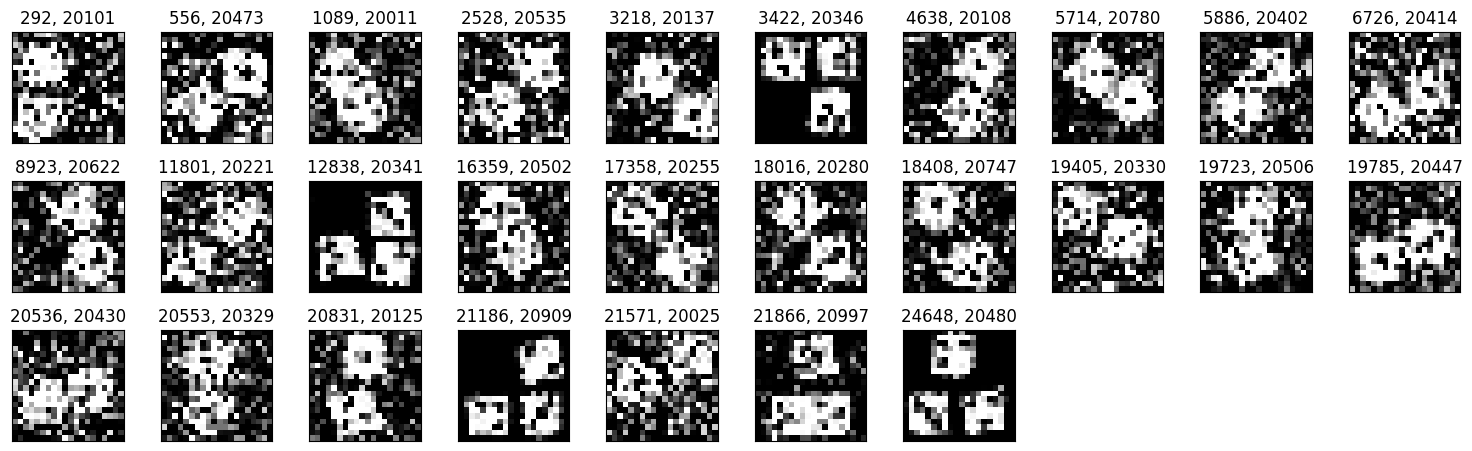

In [13]:
n = 113
fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for cnt, i in enumerate(thres_idx[:n]):
    ax = fig.add_subplot(n//10+1, 10, cnt+1)
    plt.imshow(X_test_renew[i], cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.title(f'{i}, {all_area[i]}')
    plt.tight_layout()

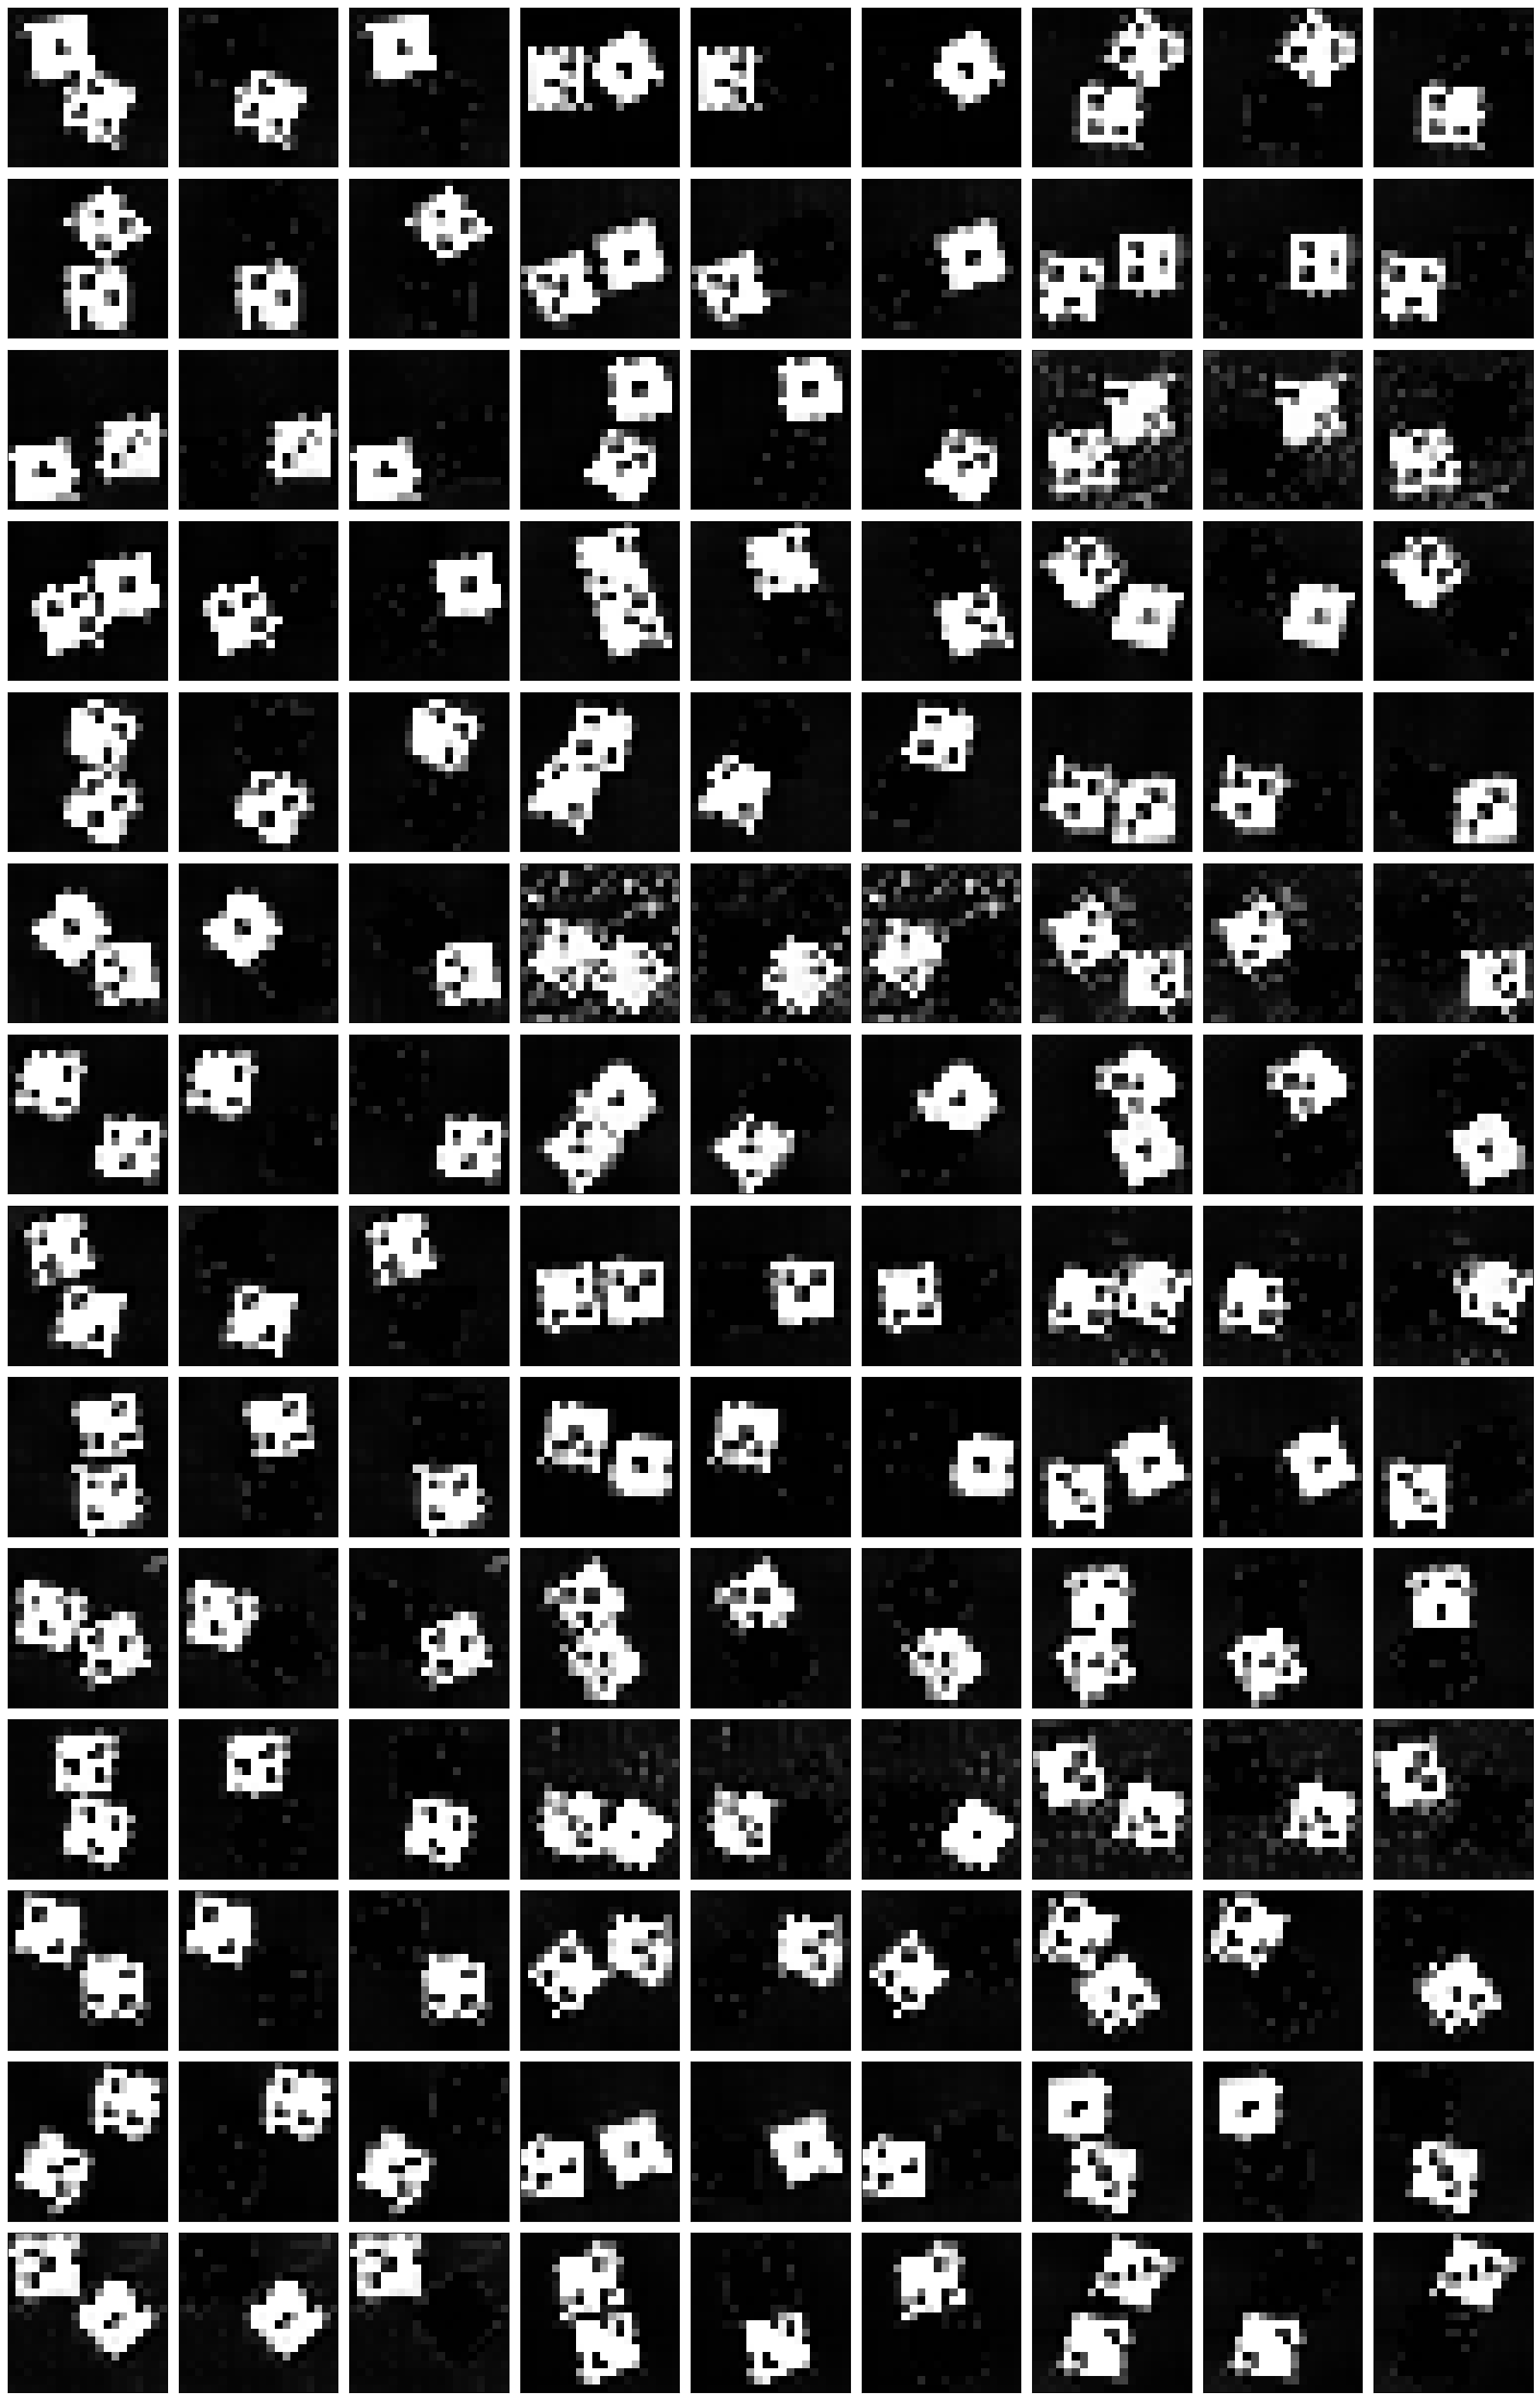

In [28]:
n = 126
fig = plt.figure(figsize=(20, 20*n//9/9))

for cnt, i in enumerate(two_dice_idx[126:(n//3)+126]):
    img = X_test_renew[i, :]
    img = cv2.fastNlMeansDenoising(src=img, h=30, templateWindowSize=3, searchWindowSize=7)

    dice_pix = []
    for j in range(20):
        for k in range(20):
            if img[j, k] >= 50:
                dice_pix.append([j, k])
    dice_pix = np.array(dice_pix)

    ax = fig.add_subplot(n//9, 9, int(3*cnt+1))
    plt.imshow(img, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

    # affinity = nearest_neightbors でうまく可視化できてる
    clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0, affinity='nearest_neighbors').fit(dice_pix)
    
    img_copy = img.copy()
    for m, [x, y] in enumerate(dice_pix):
        label = clustering.labels_[m]
        if label == 0:
            img_copy[x, y] = 1

    ax = fig.add_subplot(n//9, 9, int(3*cnt+2))
    plt.imshow(img_copy, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

    img_copy = img.copy()
    for l, [x, y] in enumerate(dice_pix):
        label = clustering.labels_[l]
        if label == 1:
            img_copy[x, y] = 1

    ax = fig.add_subplot(n//9, 9, int(3*cnt+3))
    plt.imshow(img_copy, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

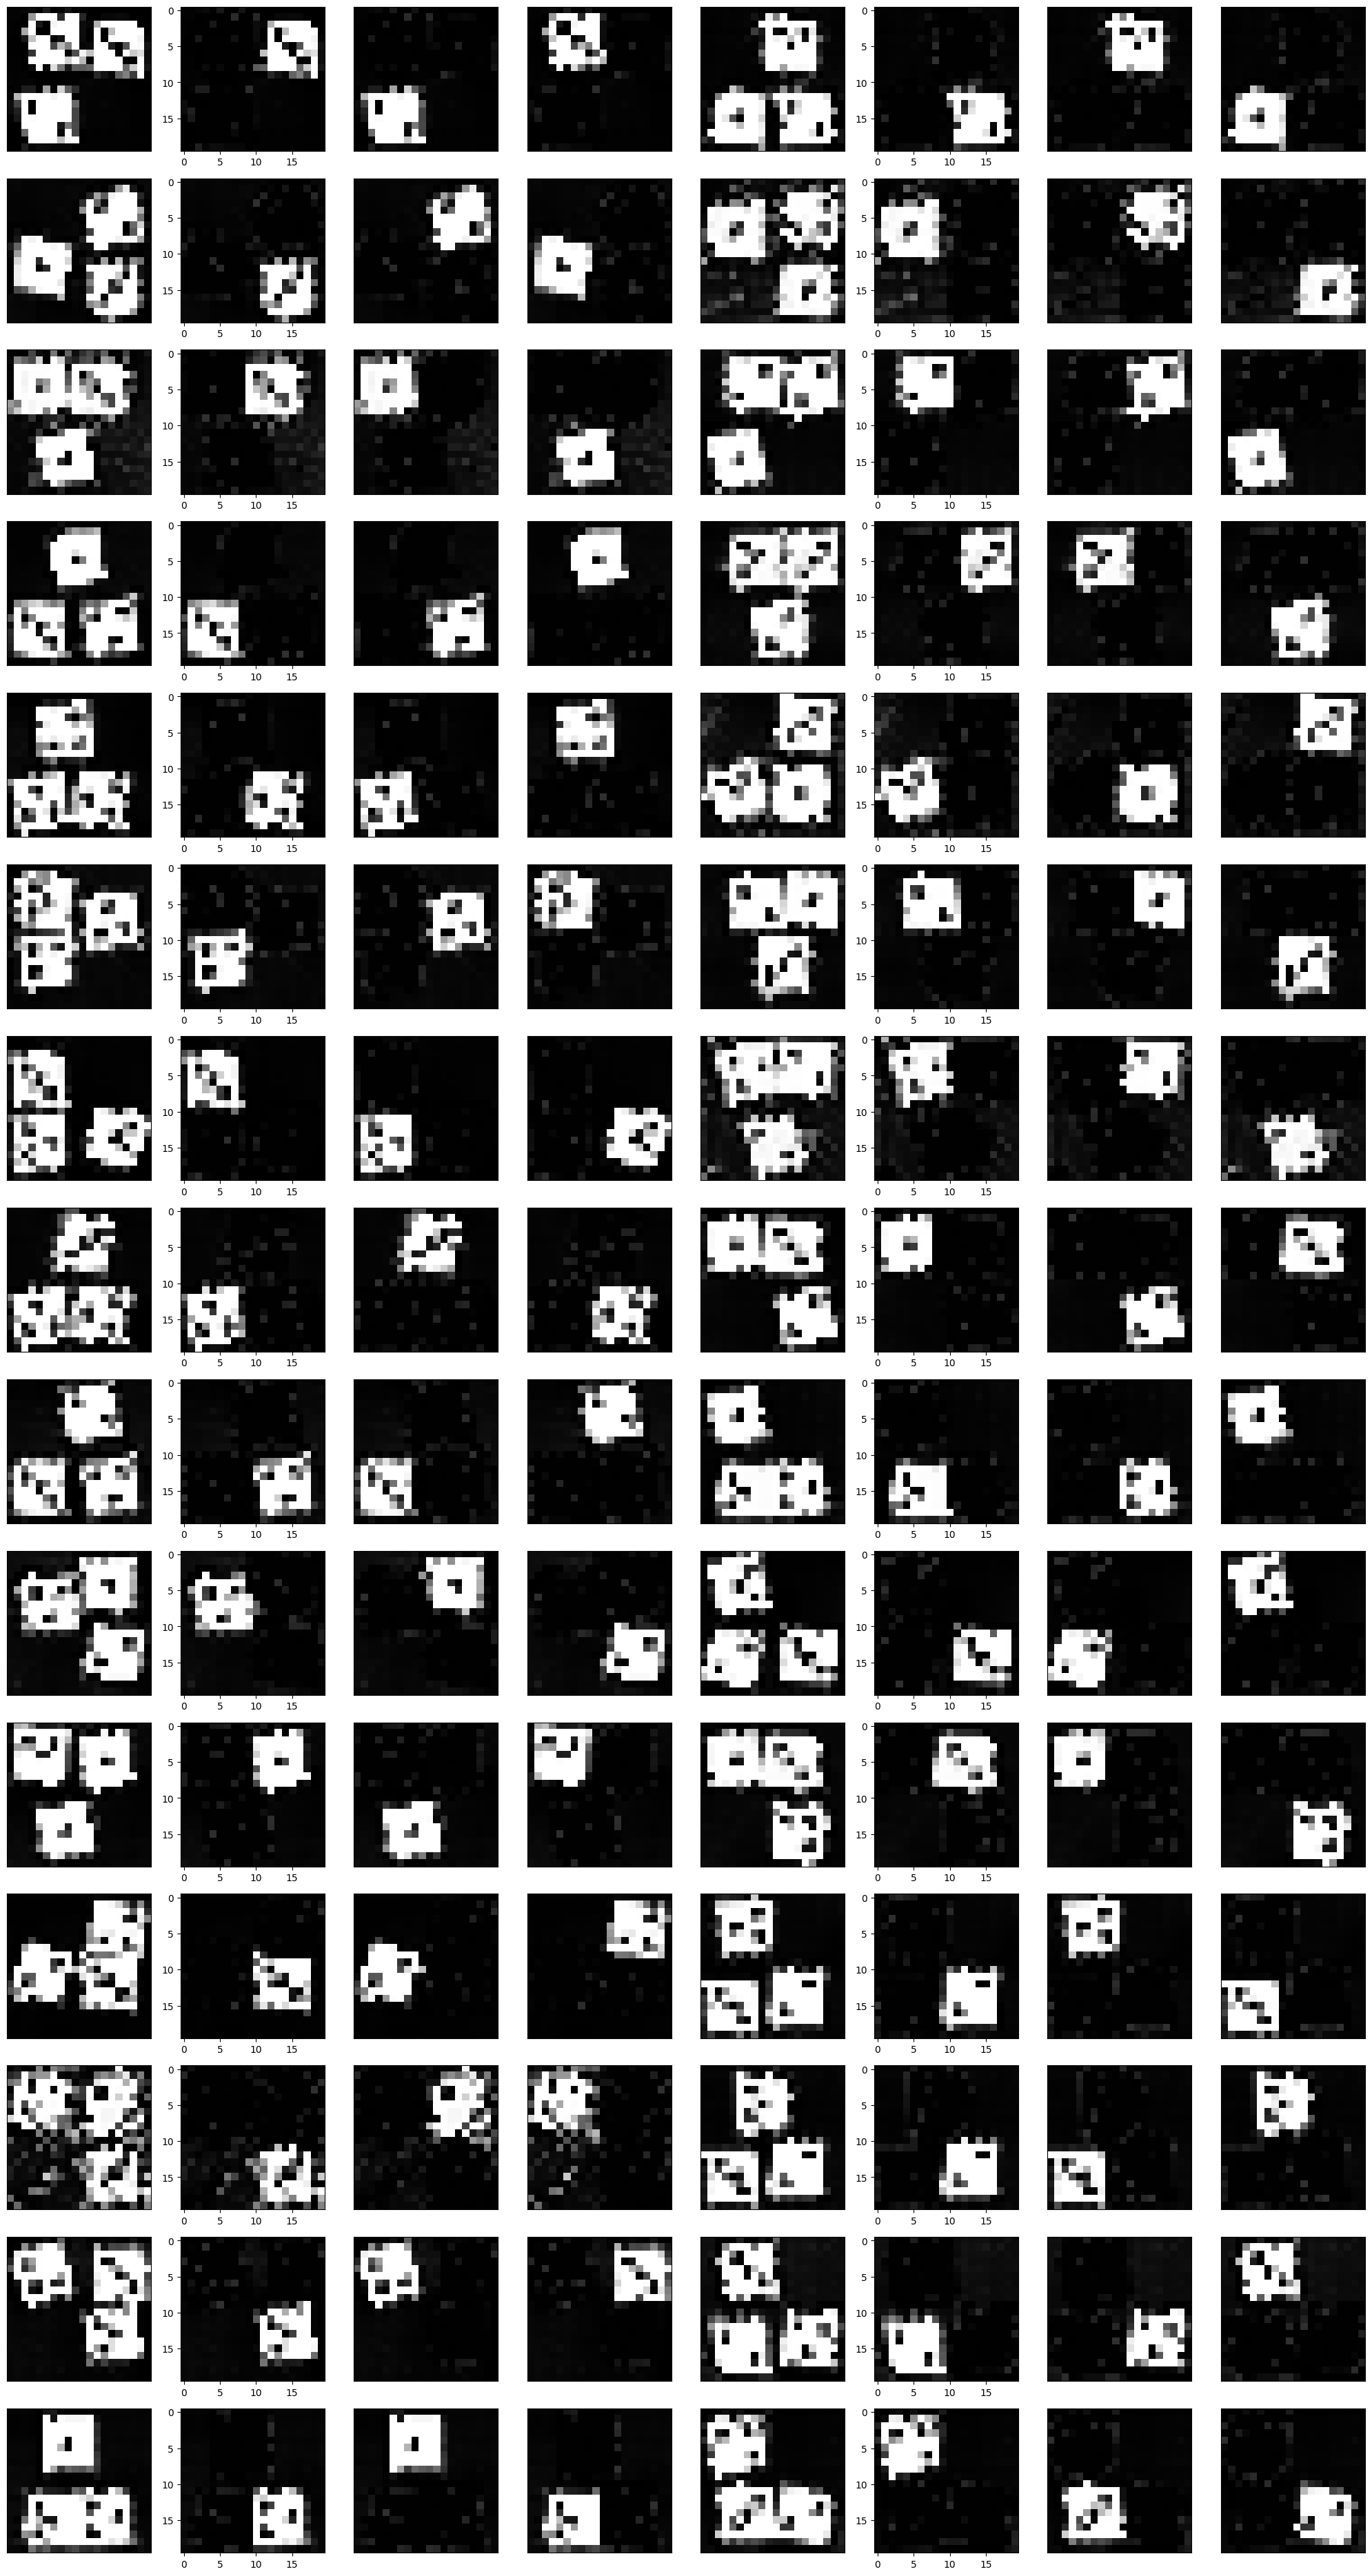

In [29]:
n = 120
fig = plt.figure(figsize=(20, 20*n//8/8))

for cnt, i in enumerate(three_dice_idx[:(n//4)]):
    img = X_test_renew[i, :]
    img = cv2.fastNlMeansDenoising(src=img, h=30, templateWindowSize=3, searchWindowSize=7)

    dice_pix = []
    for j in range(20):
        for k in range(20):
            if img[j, k] >= 50:
                dice_pix.append([j, k])
    dice_pix = np.array(dice_pix)

    ax = fig.add_subplot(n//8, 8, int(4*cnt+1))
    plt.imshow(img, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

    # affinity = nearest_neightbors でうまく可視化できてる
    clustering = SpectralClustering(n_clusters=3, assign_labels='discretize', random_state=0, affinity='nearest_neighbors').fit(dice_pix)
    
    img_copy = img.copy()
    for m, [x, y] in enumerate(dice_pix):
        label = clustering.labels_[m]
        if label == 0 or label == 1:
            img_copy[x, y] = 1

    ax = fig.add_subplot(n//8, 8, int(4*cnt+2))
    plt.imshow(img_copy, cmap='gray')
    plt.tight_layout()

    img_copy = img.copy()
    for l, [x, y] in enumerate(dice_pix):
        label = clustering.labels_[l]
        if label == 1 or label == 2:
            img_copy[x, y] = 1

    ax = fig.add_subplot(n//8, 8, int(4*cnt+3))
    plt.imshow(img_copy, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

    img_copy = img.copy()
    for m, [x, y] in enumerate(dice_pix):
        label = clustering.labels_[m]
        if label == 2 or label == 0:
            img_copy[x, y] = 1

    ax = fig.add_subplot(n//8, 8, int(4*cnt+4))
    plt.imshow(img_copy, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

##### dsets module の動作確認

In [1]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

from dsets import getIndexForEachDice
from dsets import getOneDiceImage
from dsets import devideTwoImage
from dsets import devideThreeImage
from dsets import devideImage

In [2]:
one_dice_idx_trn, two_dice_idx_trn, _ = getIndexForEachDice(data_type='trn')

In [3]:
len(one_dice_idx_trn), len(two_dice_idx_trn), len(one_dice_idx_trn) + len(two_dice_idx_trn)

(99886, 100114, 200000)

In [2]:
one_dice_idx_test, two_dice_idx_test, three_dice_idx_test = getIndexForEachDice(data_type='test')

In [5]:
len(one_dice_idx_test), len(two_dice_idx_test), len(three_dice_idx_test), len(one_dice_idx_test) + len(two_dice_idx_test) + len(three_dice_idx_test)

(7563, 6665, 10694, 24922)

In [11]:
one_dice_idx_test[-1]

24921

In [4]:
one_dice_imgs_trn = getOneDiceImage(idx=one_dice_idx_trn, data_type='trn')

In [3]:
one_dice_imgs_test = getOneDiceImage(idx=one_dice_idx_test, data_type='test')

In [13]:
len(one_dice_imgs_trn), len(one_dice_imgs_test)

(99886, 7563)

In [16]:
two_dice_imgs_trn = devideTwoImage(idx=two_dice_idx_trn, data_type='trn')

In [4]:
two_dice_imgs_test = devideTwoImage(idx=two_dice_idx_test, data_type='test')

In [ ]:
n = 50
fig = plt.figure(figsize = )

In [19]:
len(two_dice_imgs_trn), len(two_dice_imgs_test)

(200228, 13330)

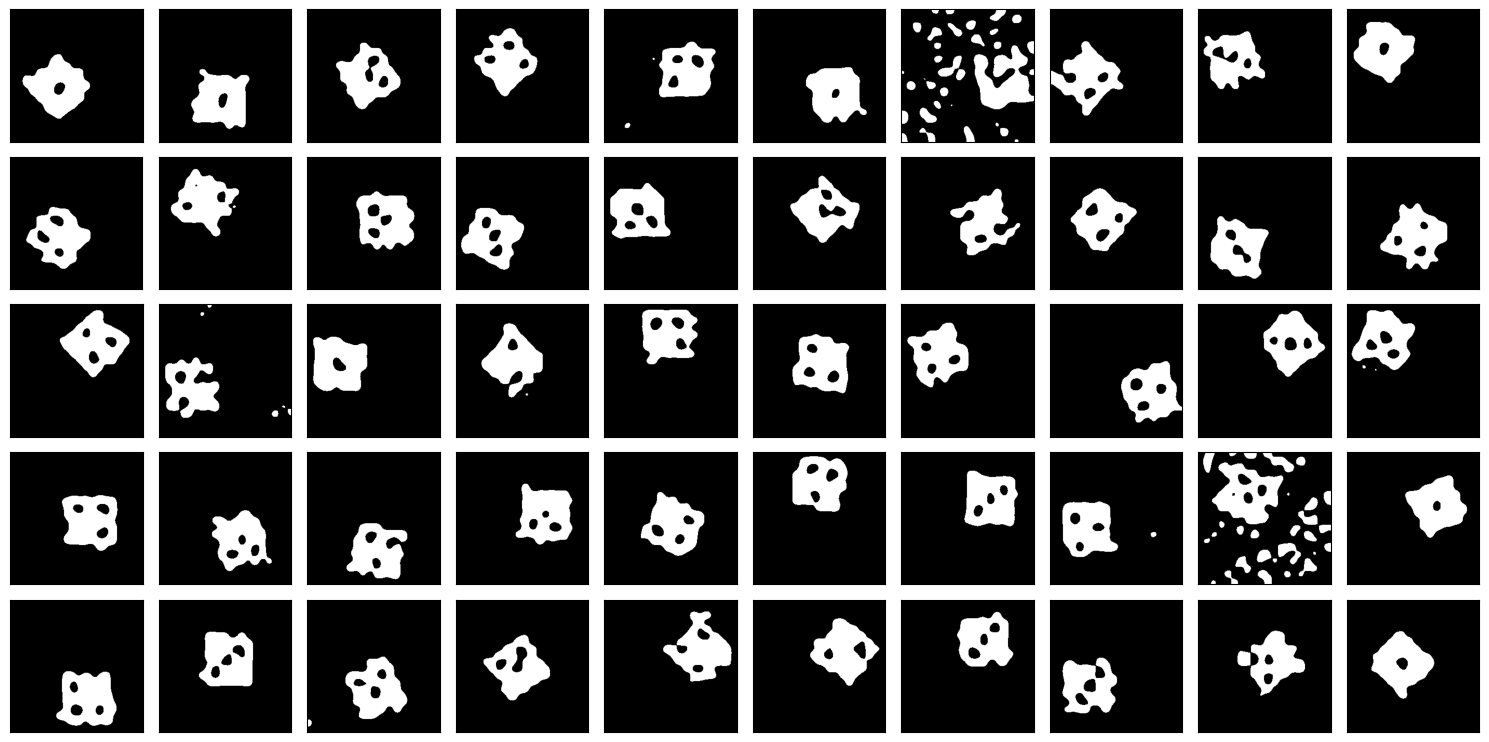

In [6]:
# test data 1つのサイコロ
n = 50
fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for cnt, img in enumerate(one_dice_imgs_test[100:n+100]):
    ax = fig.add_subplot(n//10+1, 10, cnt+1)

    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    plt.imshow(img, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

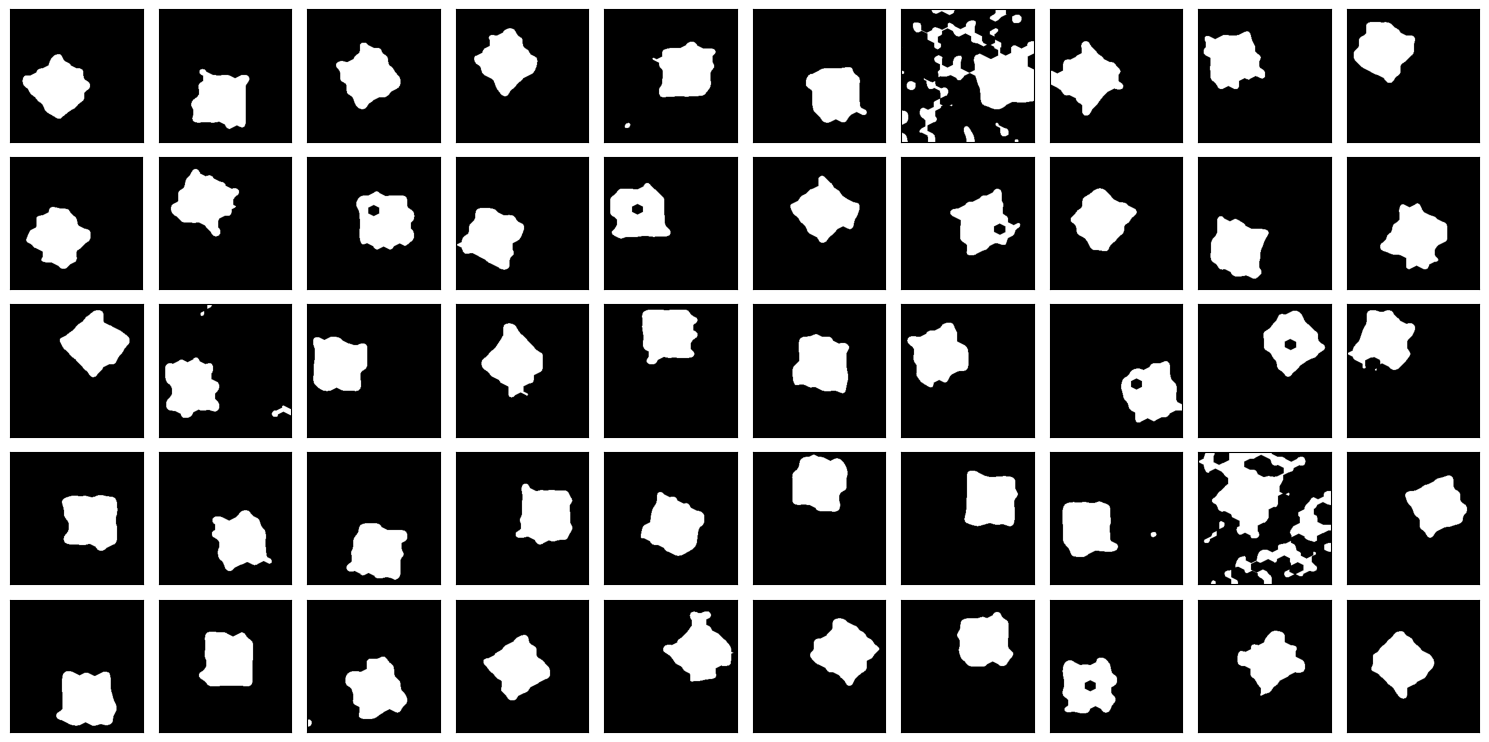

In [7]:
# test data 1つのサイコロ 思いっきりクロージング
n = 50
fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for cnt, img in enumerate(one_dice_imgs_test[100:n+100]):
    ax = fig.add_subplot(n//10+1, 10, cnt+1)

    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=5)
    
    plt.imshow(img, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

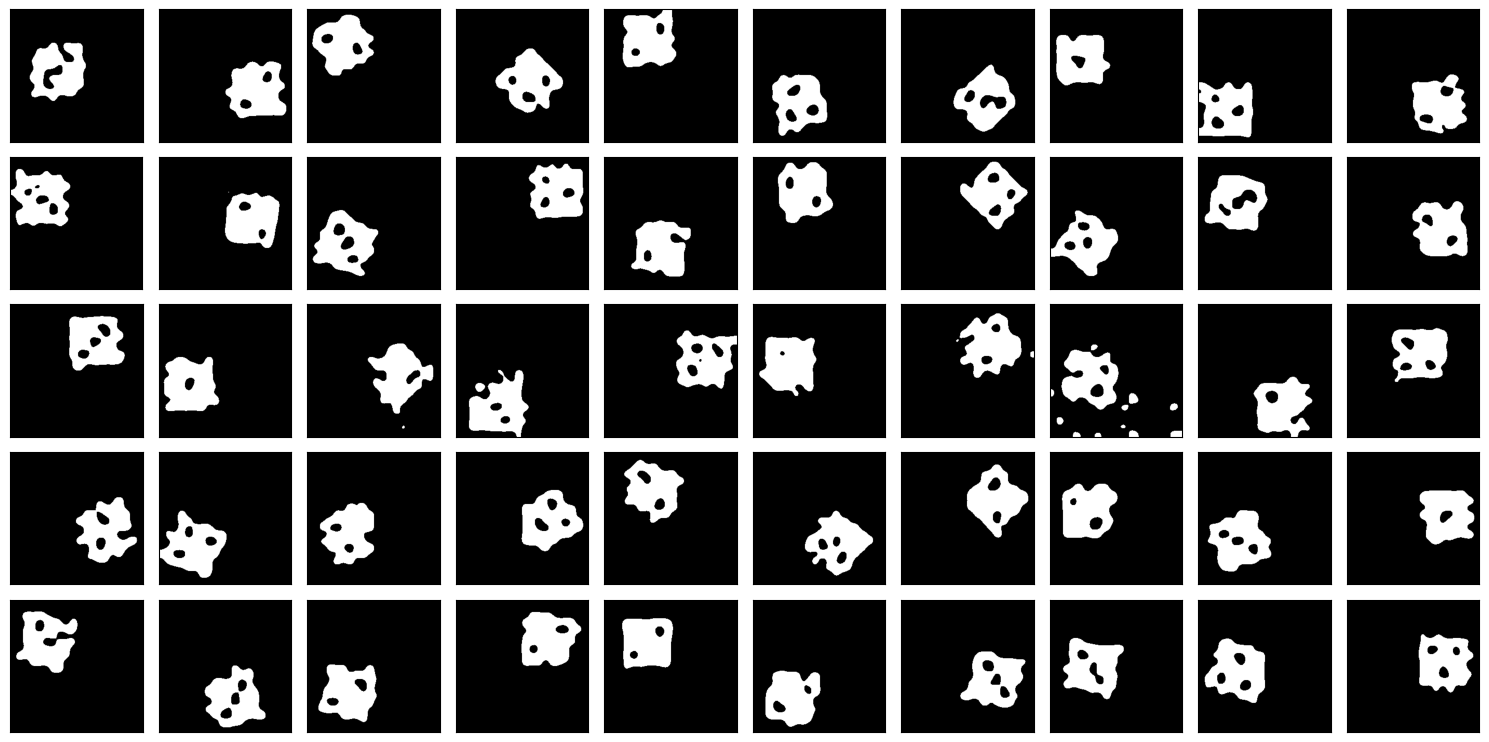

In [29]:
# test data 2つのサイコロを分けたもの
n = 50
fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for cnt, img in enumerate(two_dice_imgs_test[100:n+100]):
    ax = fig.add_subplot(n//10+1, 10, cnt+1)

    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    plt.imshow(img, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

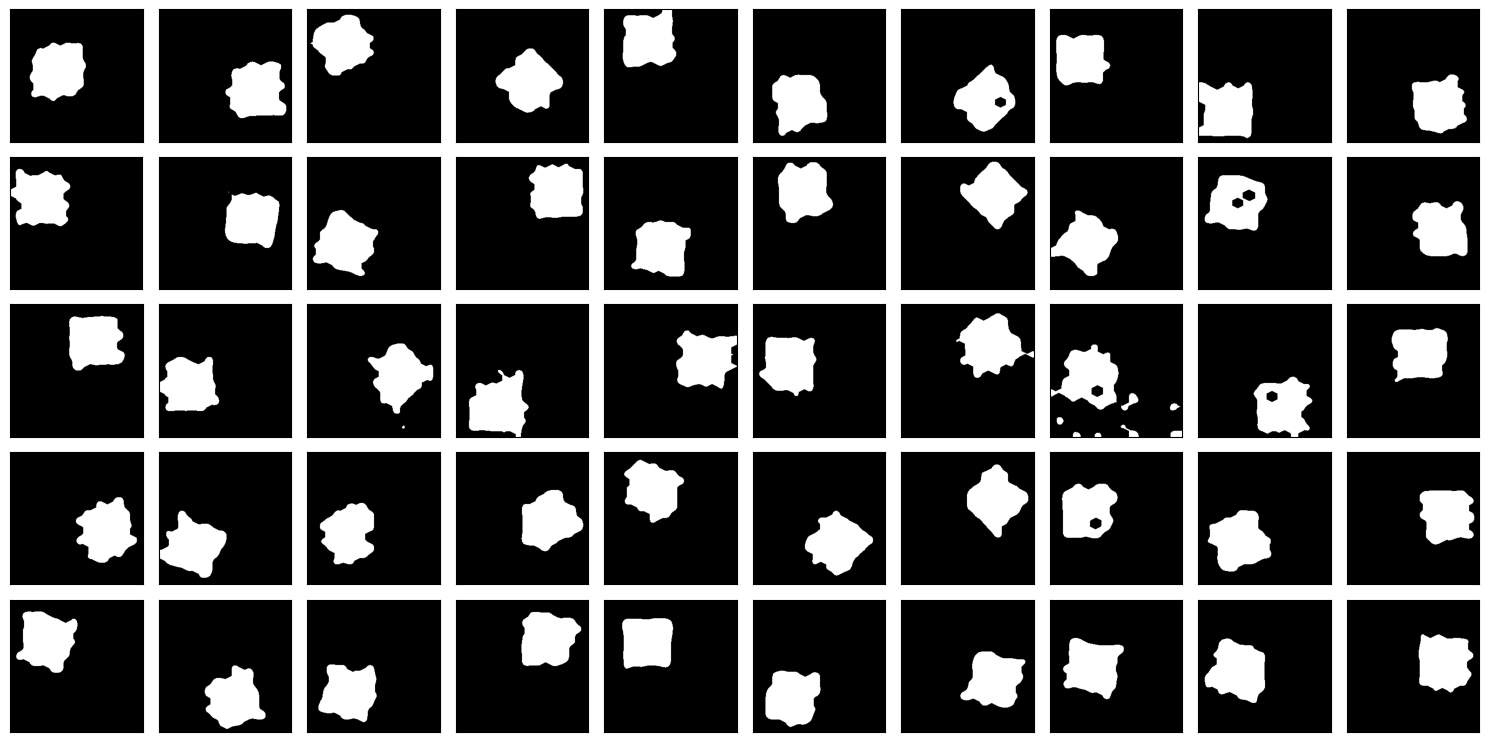

In [24]:
# test data 2つのサイコロを分けたもの 思いっきりクロージング
n = 50
fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for cnt, img in enumerate(two_dice_imgs_test[100:n+100]):
    ax = fig.add_subplot(n//10+1, 10, cnt+1)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=5)
    plt.imshow(img, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

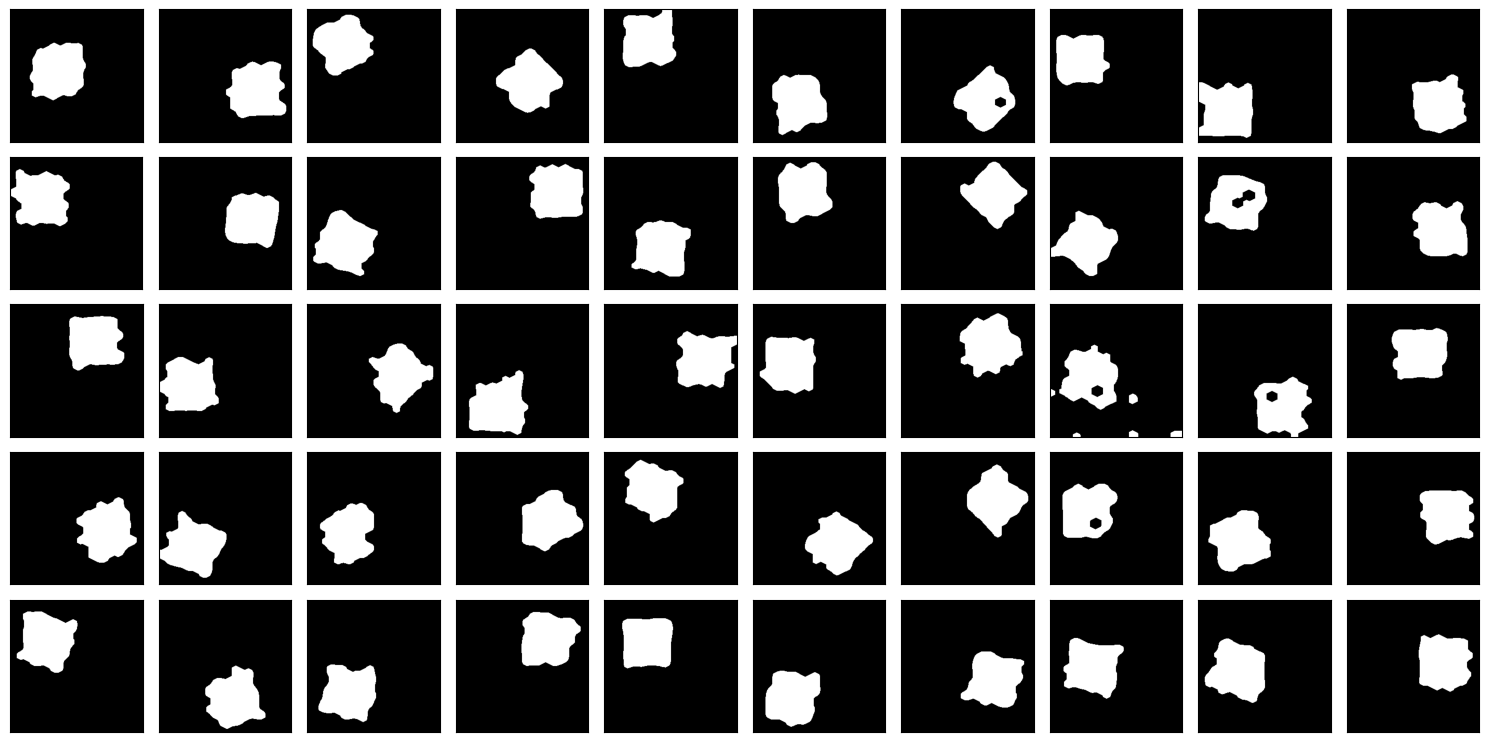

In [27]:
# test data 2つのサイコロを分けたもの 思いっきりクロージング -> オープニング
n = 50
fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for cnt, img in enumerate(two_dice_imgs_test[100:n+100]):
    ax = fig.add_subplot(n//10+1, 10, cnt+1)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=5)
    # opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=3)
    plt.imshow(img, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

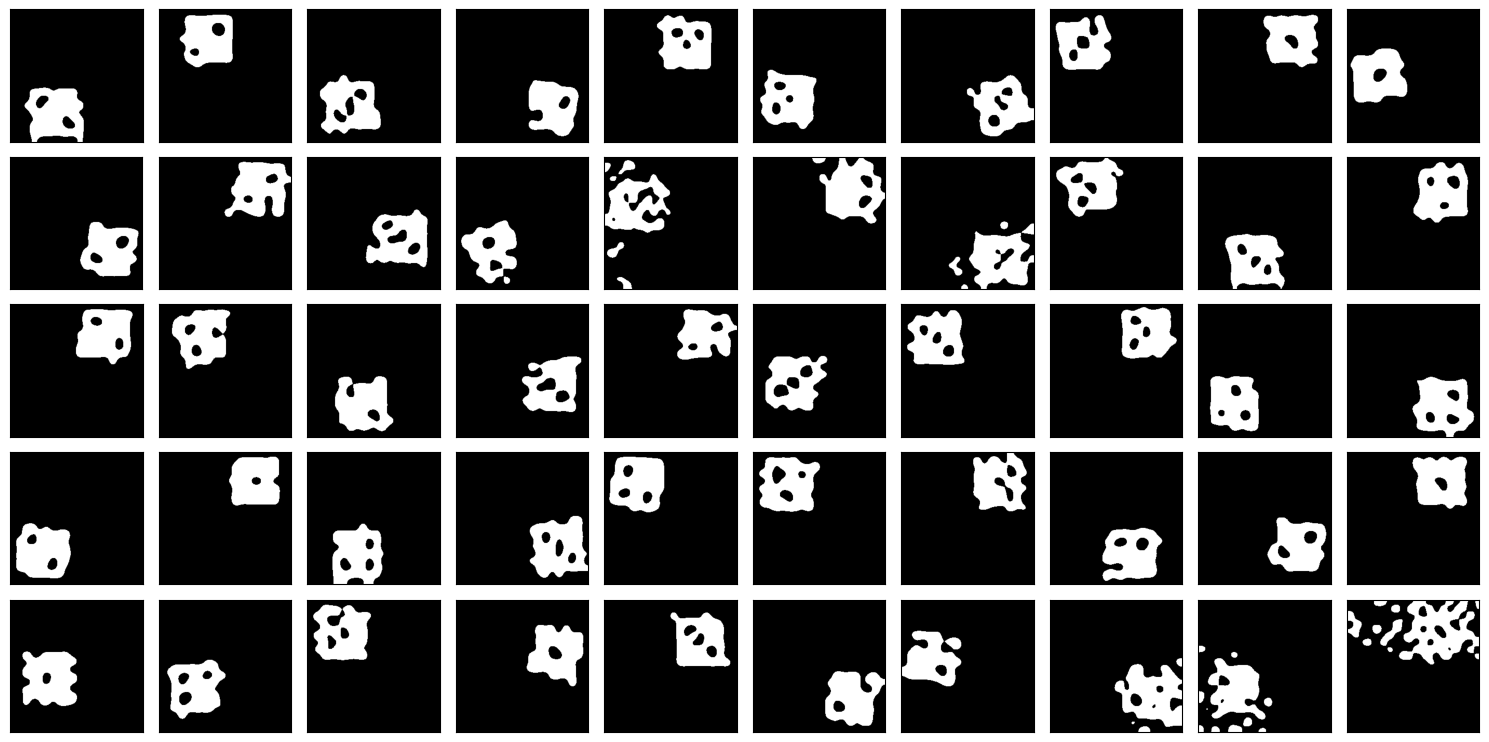

In [25]:
# test data 2つのサイコロを分けたもの
n = 50
fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for cnt, img in enumerate(three_dice_imgs_test[100:n+100]):
    ax = fig.add_subplot(n//10+1, 10, cnt+1)

    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    plt.imshow(img, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

In [5]:
three_dice_imgs_test = devideThreeImage(idx=three_dice_idx_test, data_type='test')

In [26]:
len(three_dice_idx_test)*3 == len(three_dice_imgs_test) 

True

In [6]:
from dsets import getOneDiceRectanglar

In [5]:
len(one_dice_imgs_test)

7563

In [7]:
# サイコロ１個の場合の例外処理
# サイコロを持たない画像のリスト
no_dice_imgs_ONEDICE = []

# サイコロを2つ以上もつ画像のリスト
multi_dice_imgs_ONEDICE = []

no_dices_all = 0
more_than_two_dice_all = 0
for img in one_dice_imgs_test:
    no_dice, more_than_two_dice = getOneDiceRectanglar(img, data_type='test')
    assert no_dice in [0, 1]
    assert more_than_two_dice in [0, 1]

    if no_dice == 1:
        no_dice_imgs_ONEDICE.append(img)
    if more_than_two_dice == 1:
        multi_dice_imgs_ONEDICE.append(img)

In [8]:
len(no_dice_imgs_ONEDICE), len(multi_dice_imgs_ONEDICE)

(69, 1)

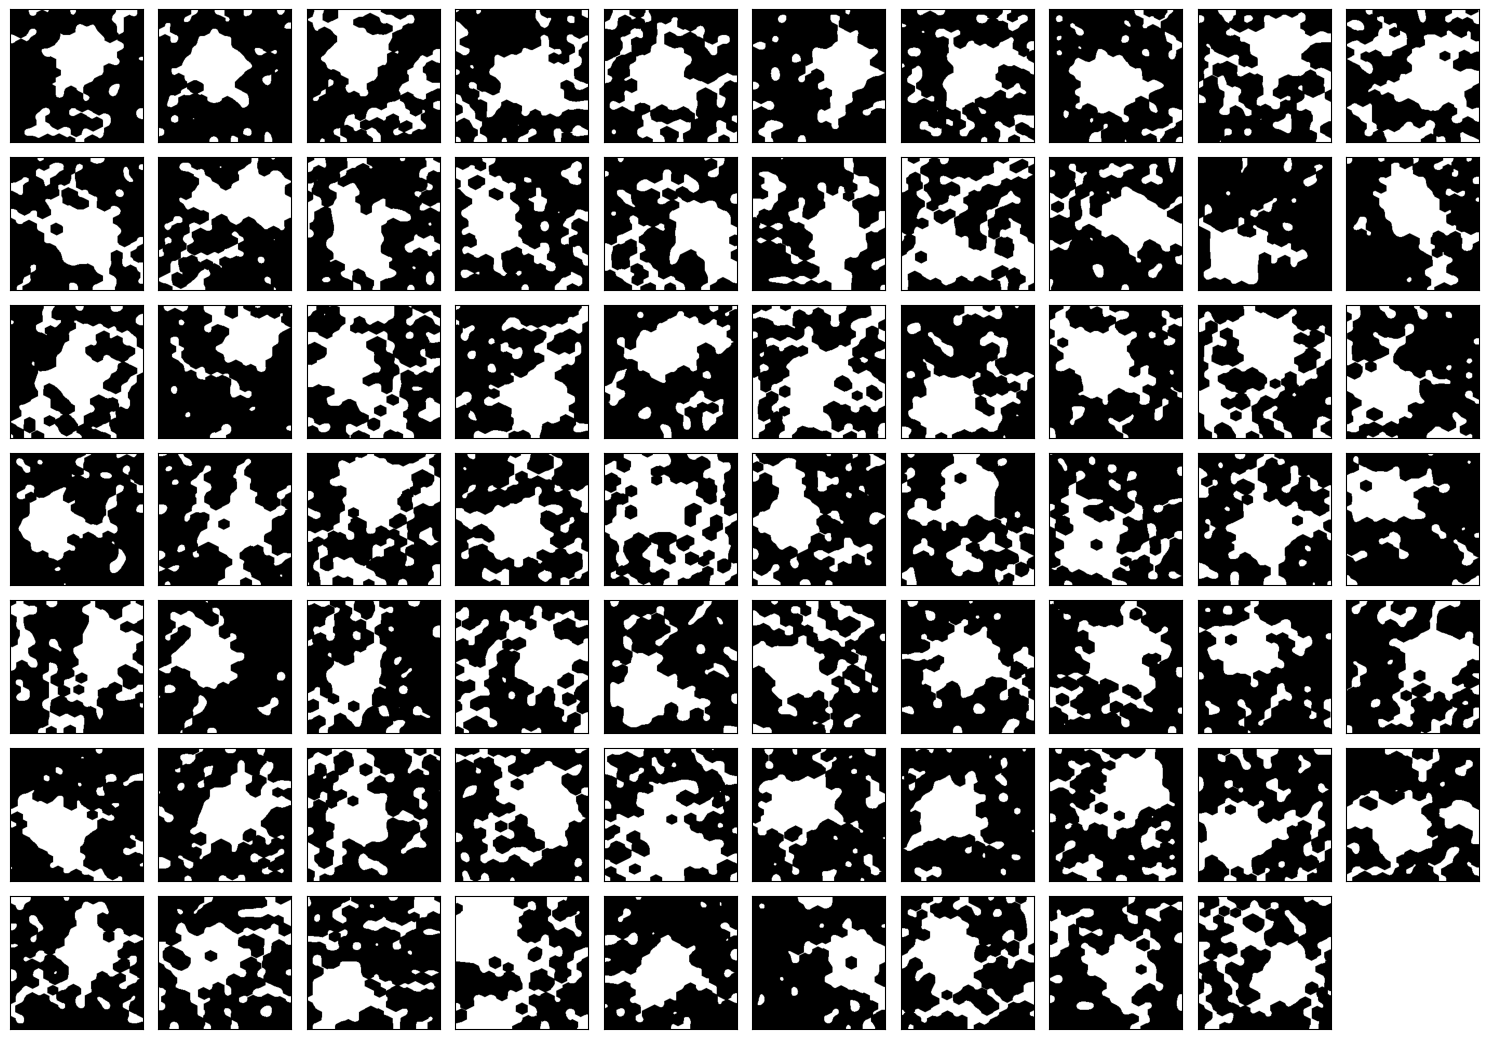

In [9]:
# サイコロが0
n = len(no_dice_imgs_ONEDICE)

fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for cnt, img in enumerate(no_dice_imgs_ONEDICE):
    ax = fig.add_subplot(n//10+1, 10, cnt+1)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=5)
    plt.imshow(img, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

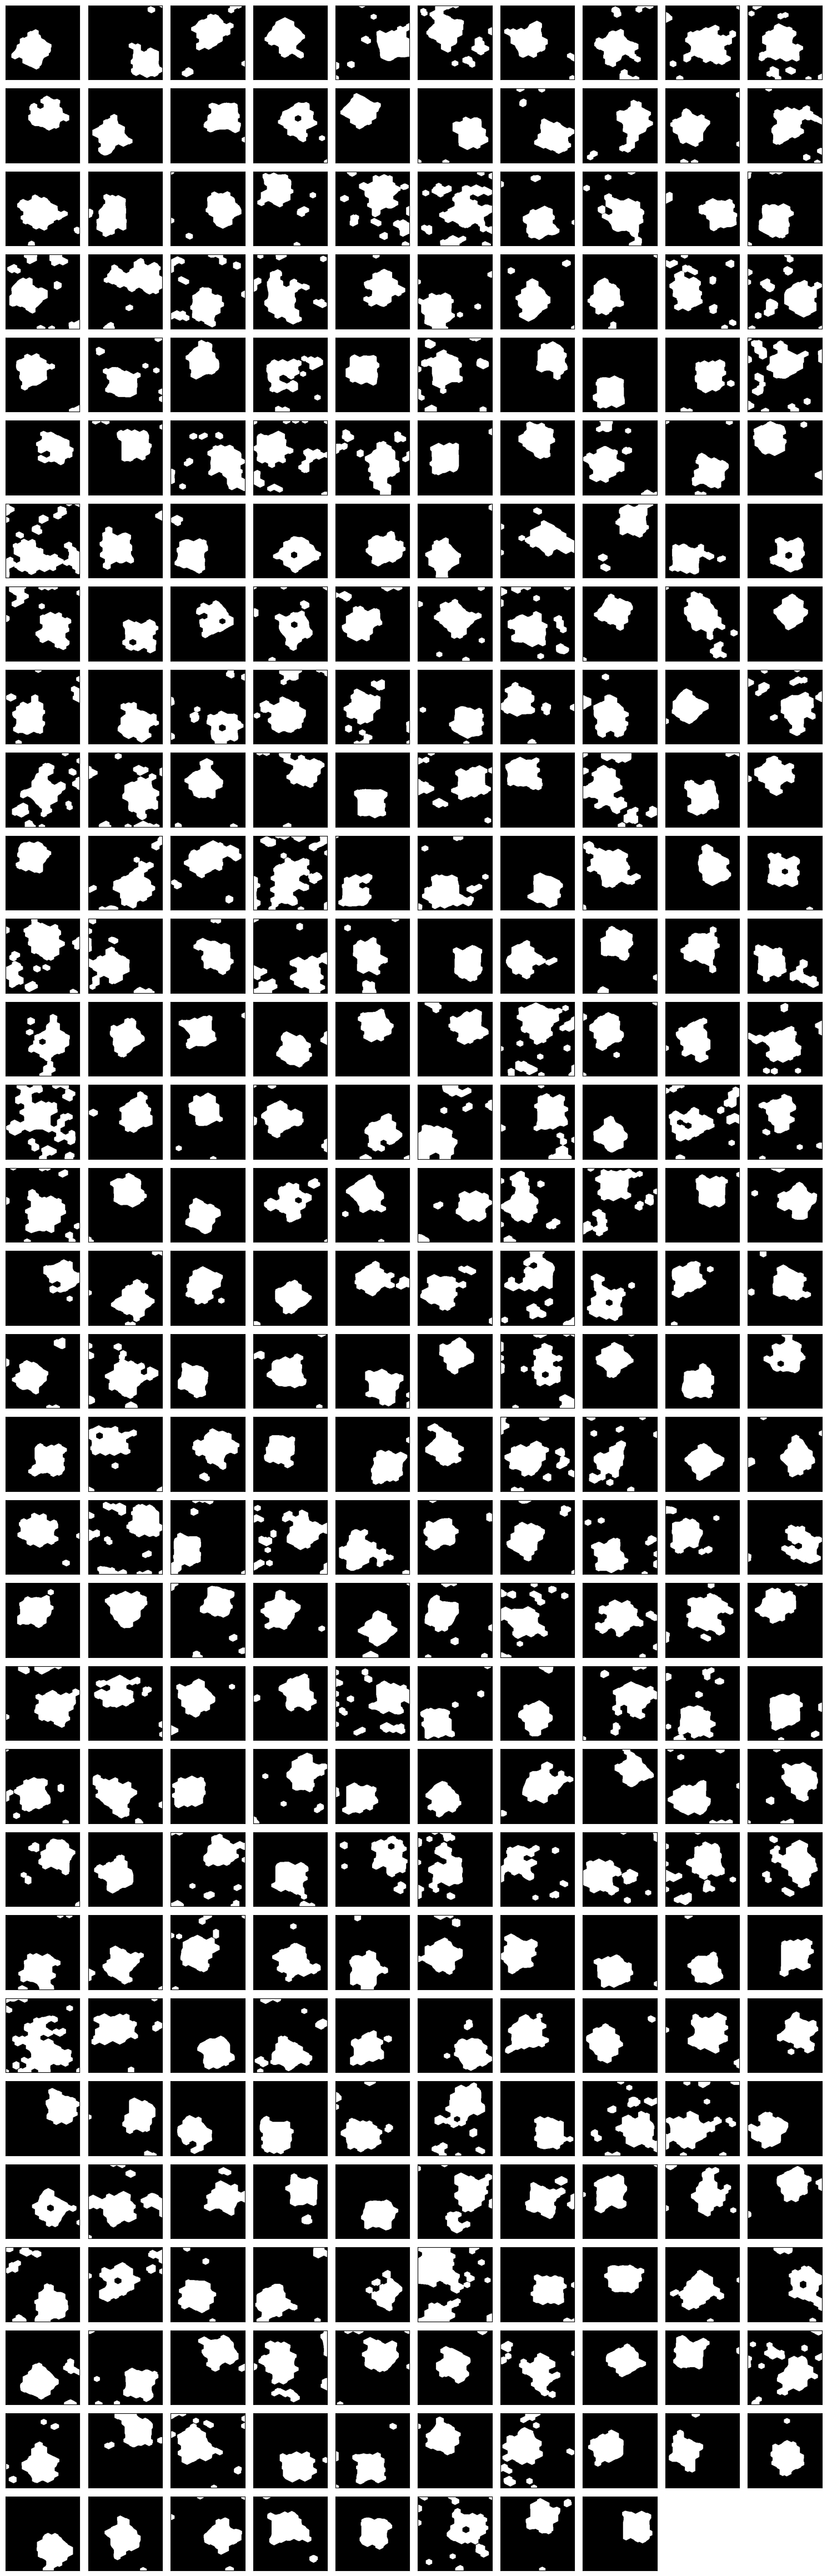

In [29]:
# サイコロが0
n = len(no_dice_imgs_ONEDICE)

fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for cnt, img in enumerate(no_dice_imgs_ONEDICE):
    ax = fig.add_subplot(n//10+1, 10, cnt+1)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=5)
    # opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=5)
    plt.imshow(img, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

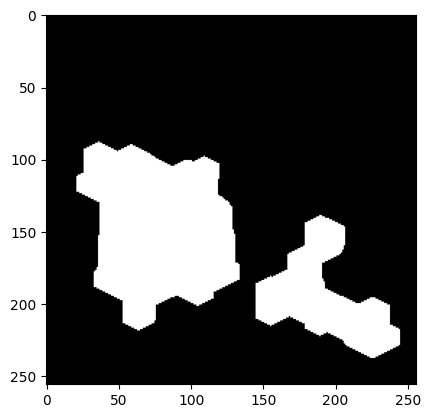

In [18]:
# サイコロが2つ以上
img = multi_dice_imgs_ONEDICE[0]
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=5)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=5)
plt.imshow(img, cmap='gray')

In [19]:
# サイコロ2個の場合の例外処理
# サイコロを持たない画像のリスト
no_dice_imgs_TWODICE = []

# サイコロを2つ以上もつ画像のリスト
multi_dice_imgs_TWODICE = []

no_dices_all = 0
more_than_two_dice_all = 0
for img in two_dice_imgs_test:
    no_dice, more_than_two_dice = getOneDiceRectanglar(img, data_type='test')
    assert no_dice in [0, 1]
    assert more_than_two_dice in [0, 1]

    if no_dice == 1:
        no_dice_imgs_TWODICE.append(img)
    if more_than_two_dice == 1:
        multi_dice_imgs_TWODICE.append(img)

In [12]:
len(no_dice_imgs_TWODICE), len(multi_dice_imgs_TWODICE)

(108, 0)

In [13]:
# サイコロ3個の場合の例外処理
# サイコロを持たない画像のリスト
no_dice_imgs_THREEDICE = []

# サイコロを2つ以上もつ画像のリスト
multi_dice_imgs_THREEDICE = []

no_dices_all = 0
more_than_two_dice_all = 0
for img in three_dice_imgs_test:
    no_dice, more_than_two_dice = getOneDiceRectanglar(img, data_type='test')
    assert no_dice in [0, 1]
    assert more_than_two_dice in [0, 1]

    if no_dice == 1:
        no_dice_imgs_THREEDICE.append(img)
    if more_than_two_dice == 1:
        multi_dice_imgs_THREEDICE.append(img)

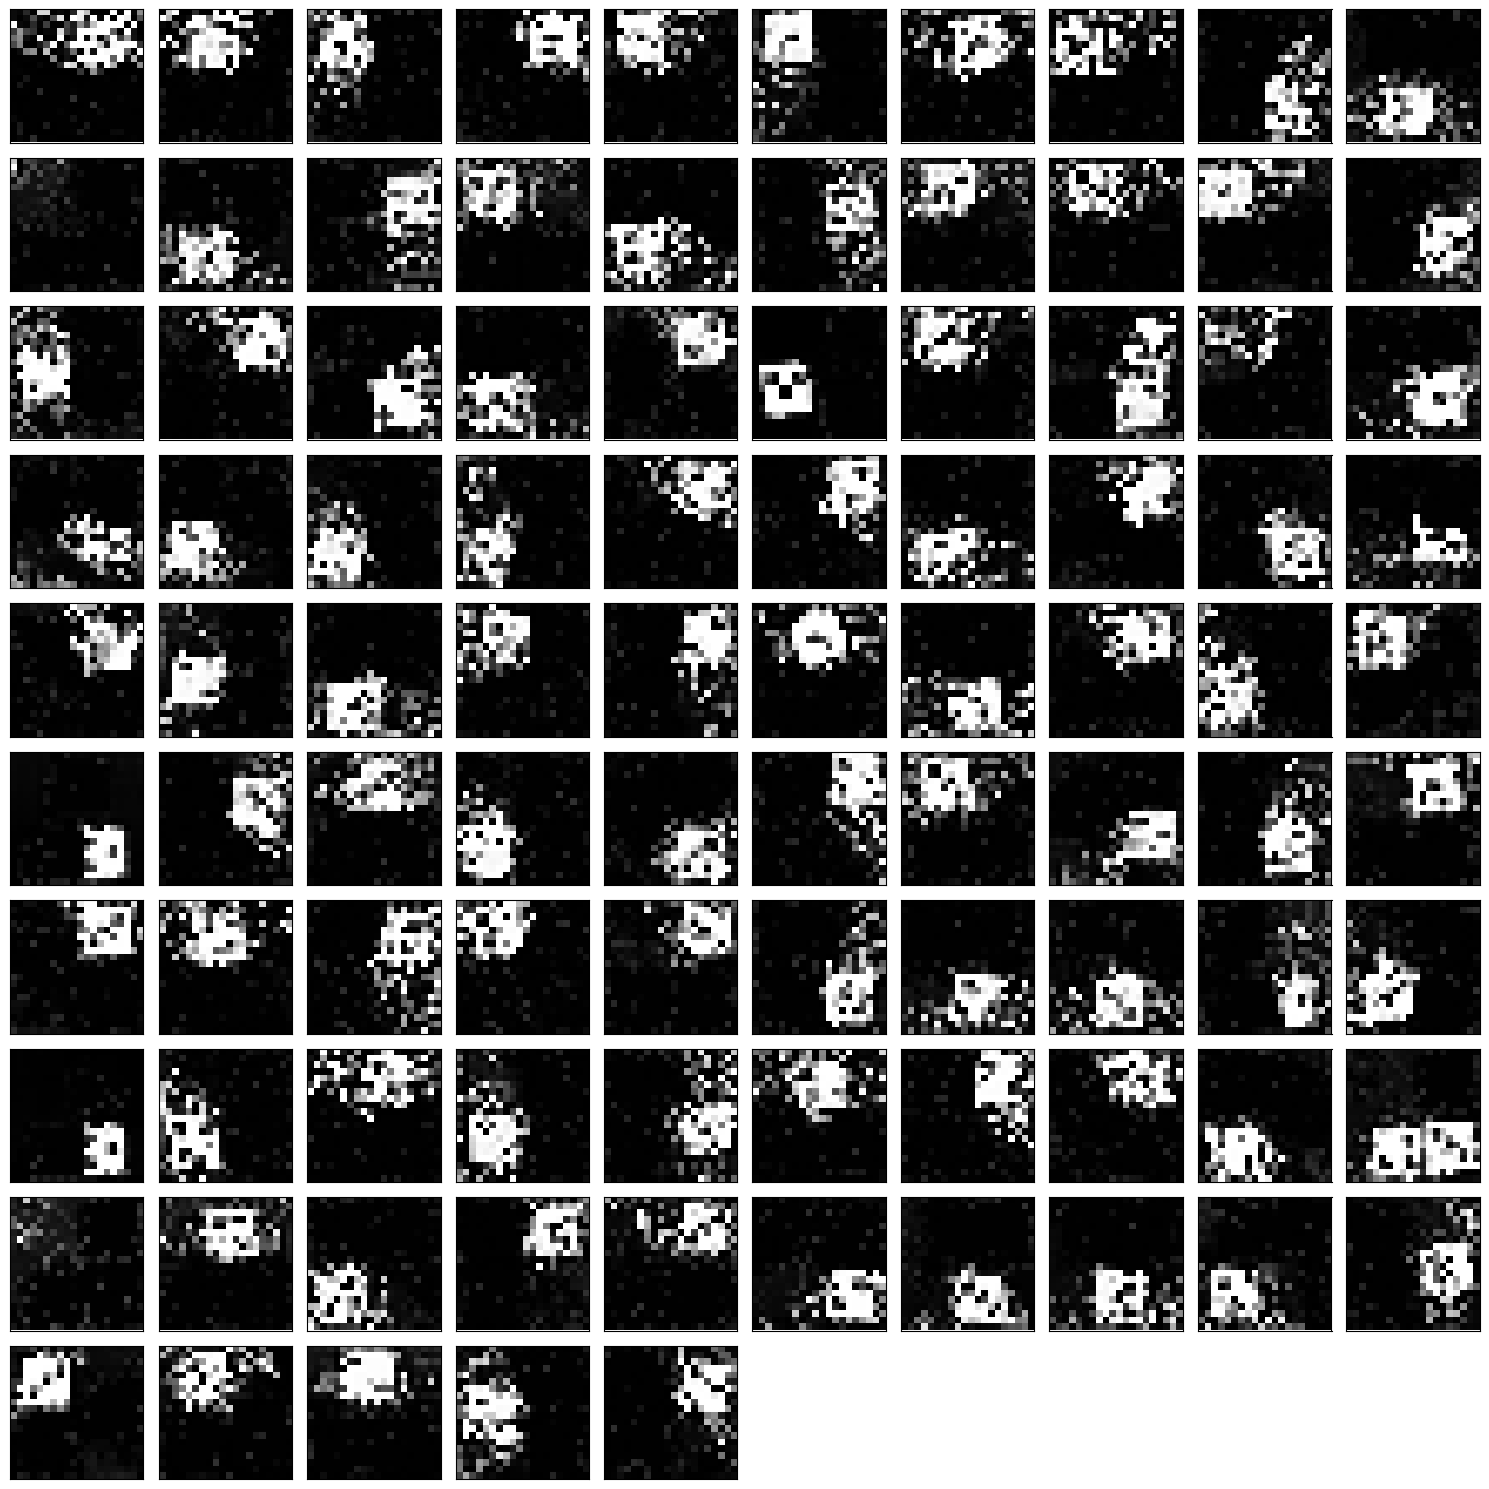

In [27]:
# サイコロが0
n = len(no_dice_imgs_THREEDICE)

fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for cnt, img in enumerate(no_dice_imgs_THREEDICE):
    ax = fig.add_subplot(n//10+1, 10, cnt+1)
    # img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    # thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # # closing
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=5)
    # # opening
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    # img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=5)
    plt.imshow(img, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()

In [15]:
len(no_dice_imgs_THREEDICE), len(multi_dice_imgs_THREEDICE)

(95, 1)

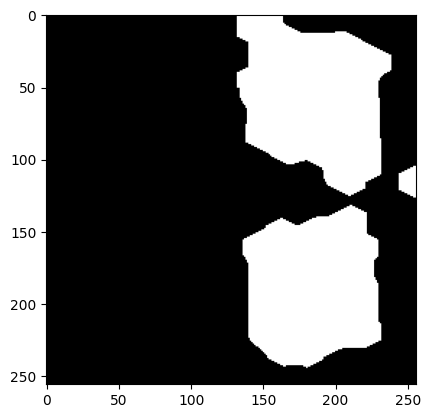

In [28]:
# サイコロが2つ以上
img = multi_dice_imgs_THREEDICE[0]
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=5)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=5)
plt.imshow(img, cmap='gray')

In [3]:
from dsets import getCroppedImgInfoList
imgs_list = getCroppedImgInfoList(data_type='test')

In [4]:
len(imgs_list)

52975

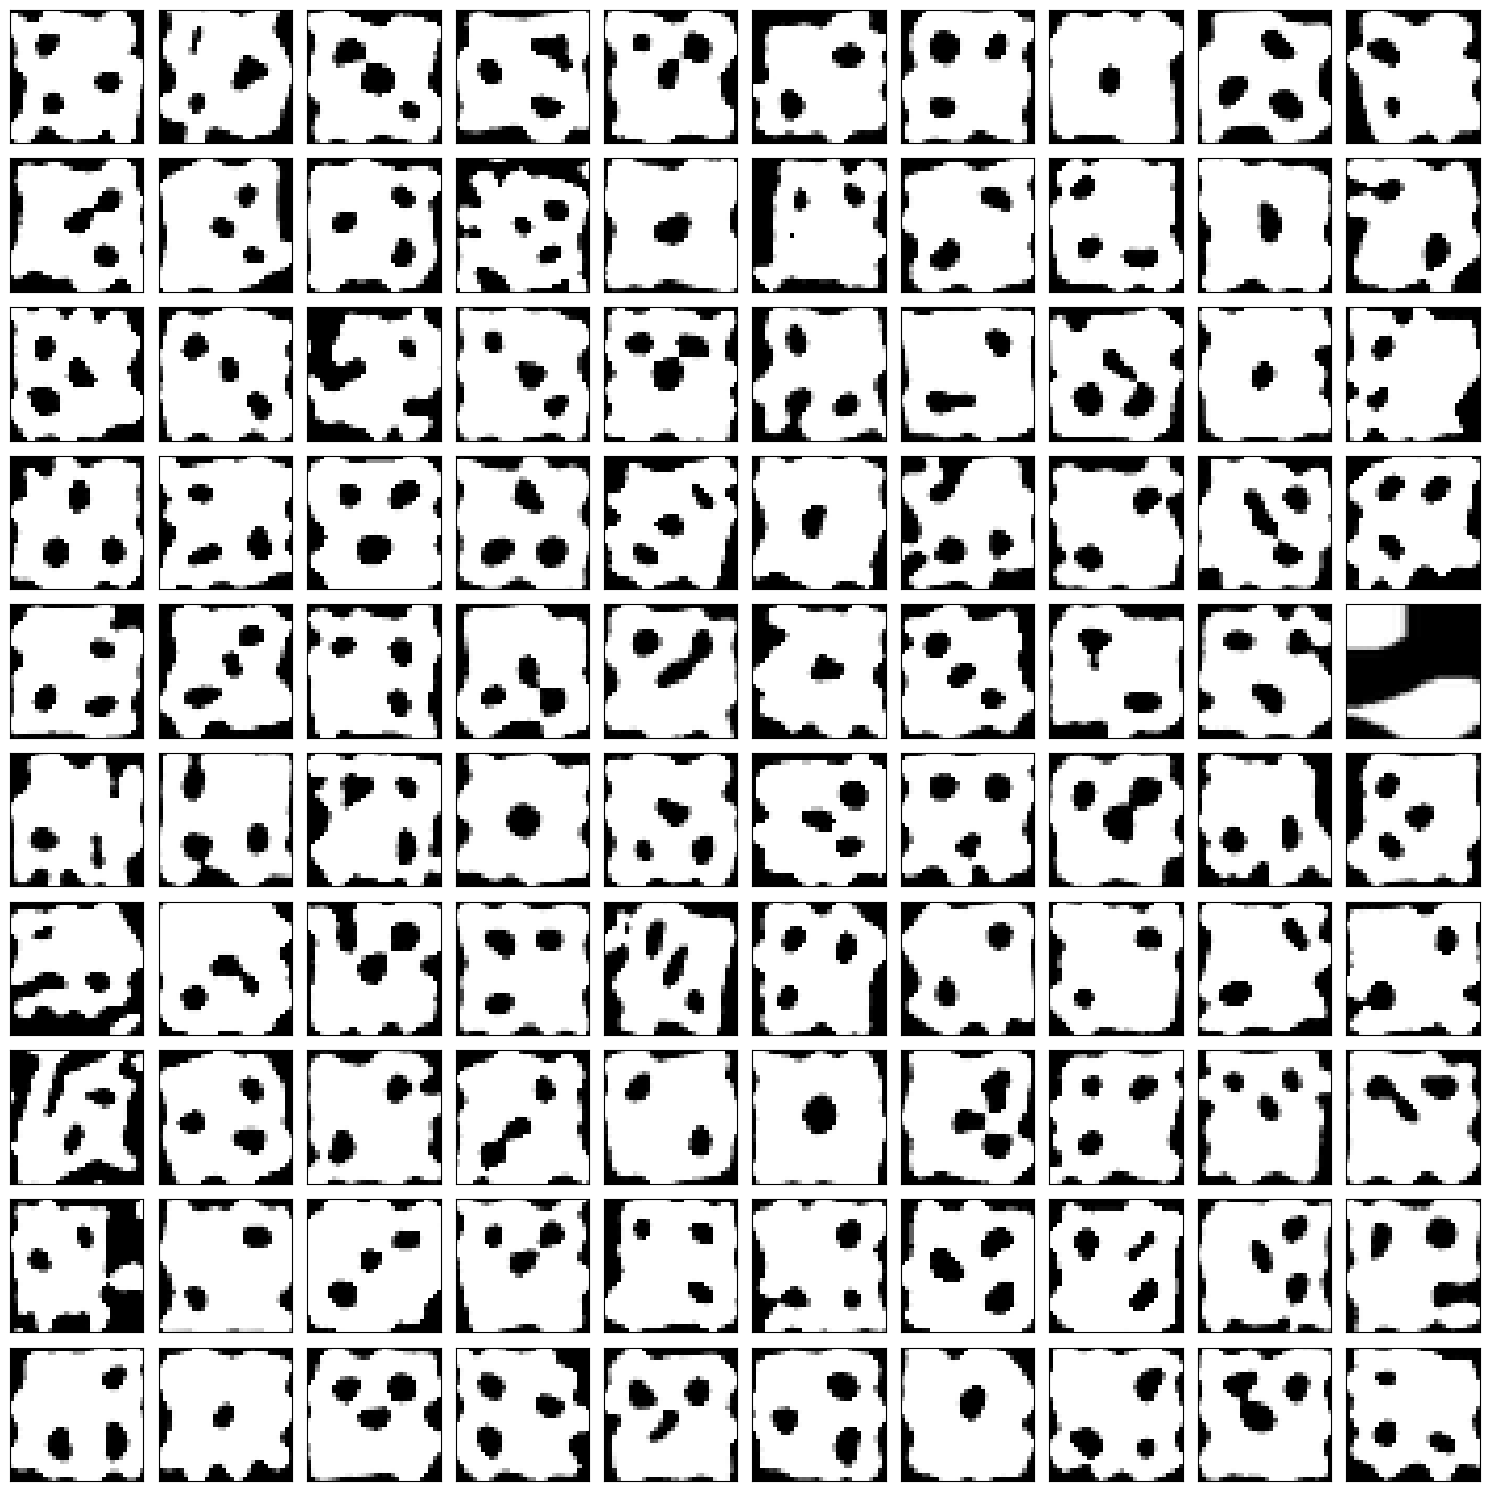

In [7]:
# サイコロが0
n = 100

fig = plt.figure(figsize=(15, 15*((n//10+1)/10)))

for cnt, img in enumerate(imgs_list[:100]):
    ax = fig.add_subplot(n//10+1, 10, cnt+1)
    plt.imshow(img, cmap='gray')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()